In [1]:
from IPython.display import display
from ipywidgets import FloatProgress

import sys
sys.path.append('../src')

import neuralnetworkclassifier as nnc
import mlutils as ml

import numpy as np
import pandas as pd
import itertools
import copy
import pickle
import glob

import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
plt.style.use('seaborn-whitegrid')

In [2]:
!curl -O http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvf cifar-10-python.tar.gz


x cifar-10-batches-py/
x cifar-10-batches-py/data_batch_4
x cifar-10-batches-py/readme.html
x cifar-10-batches-py/test_batch
x cifar-10-batches-py/data_batch_3
x cifar-10-batches-py/batches.meta
x cifar-10-batches-py/data_batch_2
x cifar-10-batches-py/data_batch_5
x cifar-10-batches-py/data_batch_1


(50000, 3, 32, 32) (50000, 1) (10000, 3, 32, 32) (10000, 1)


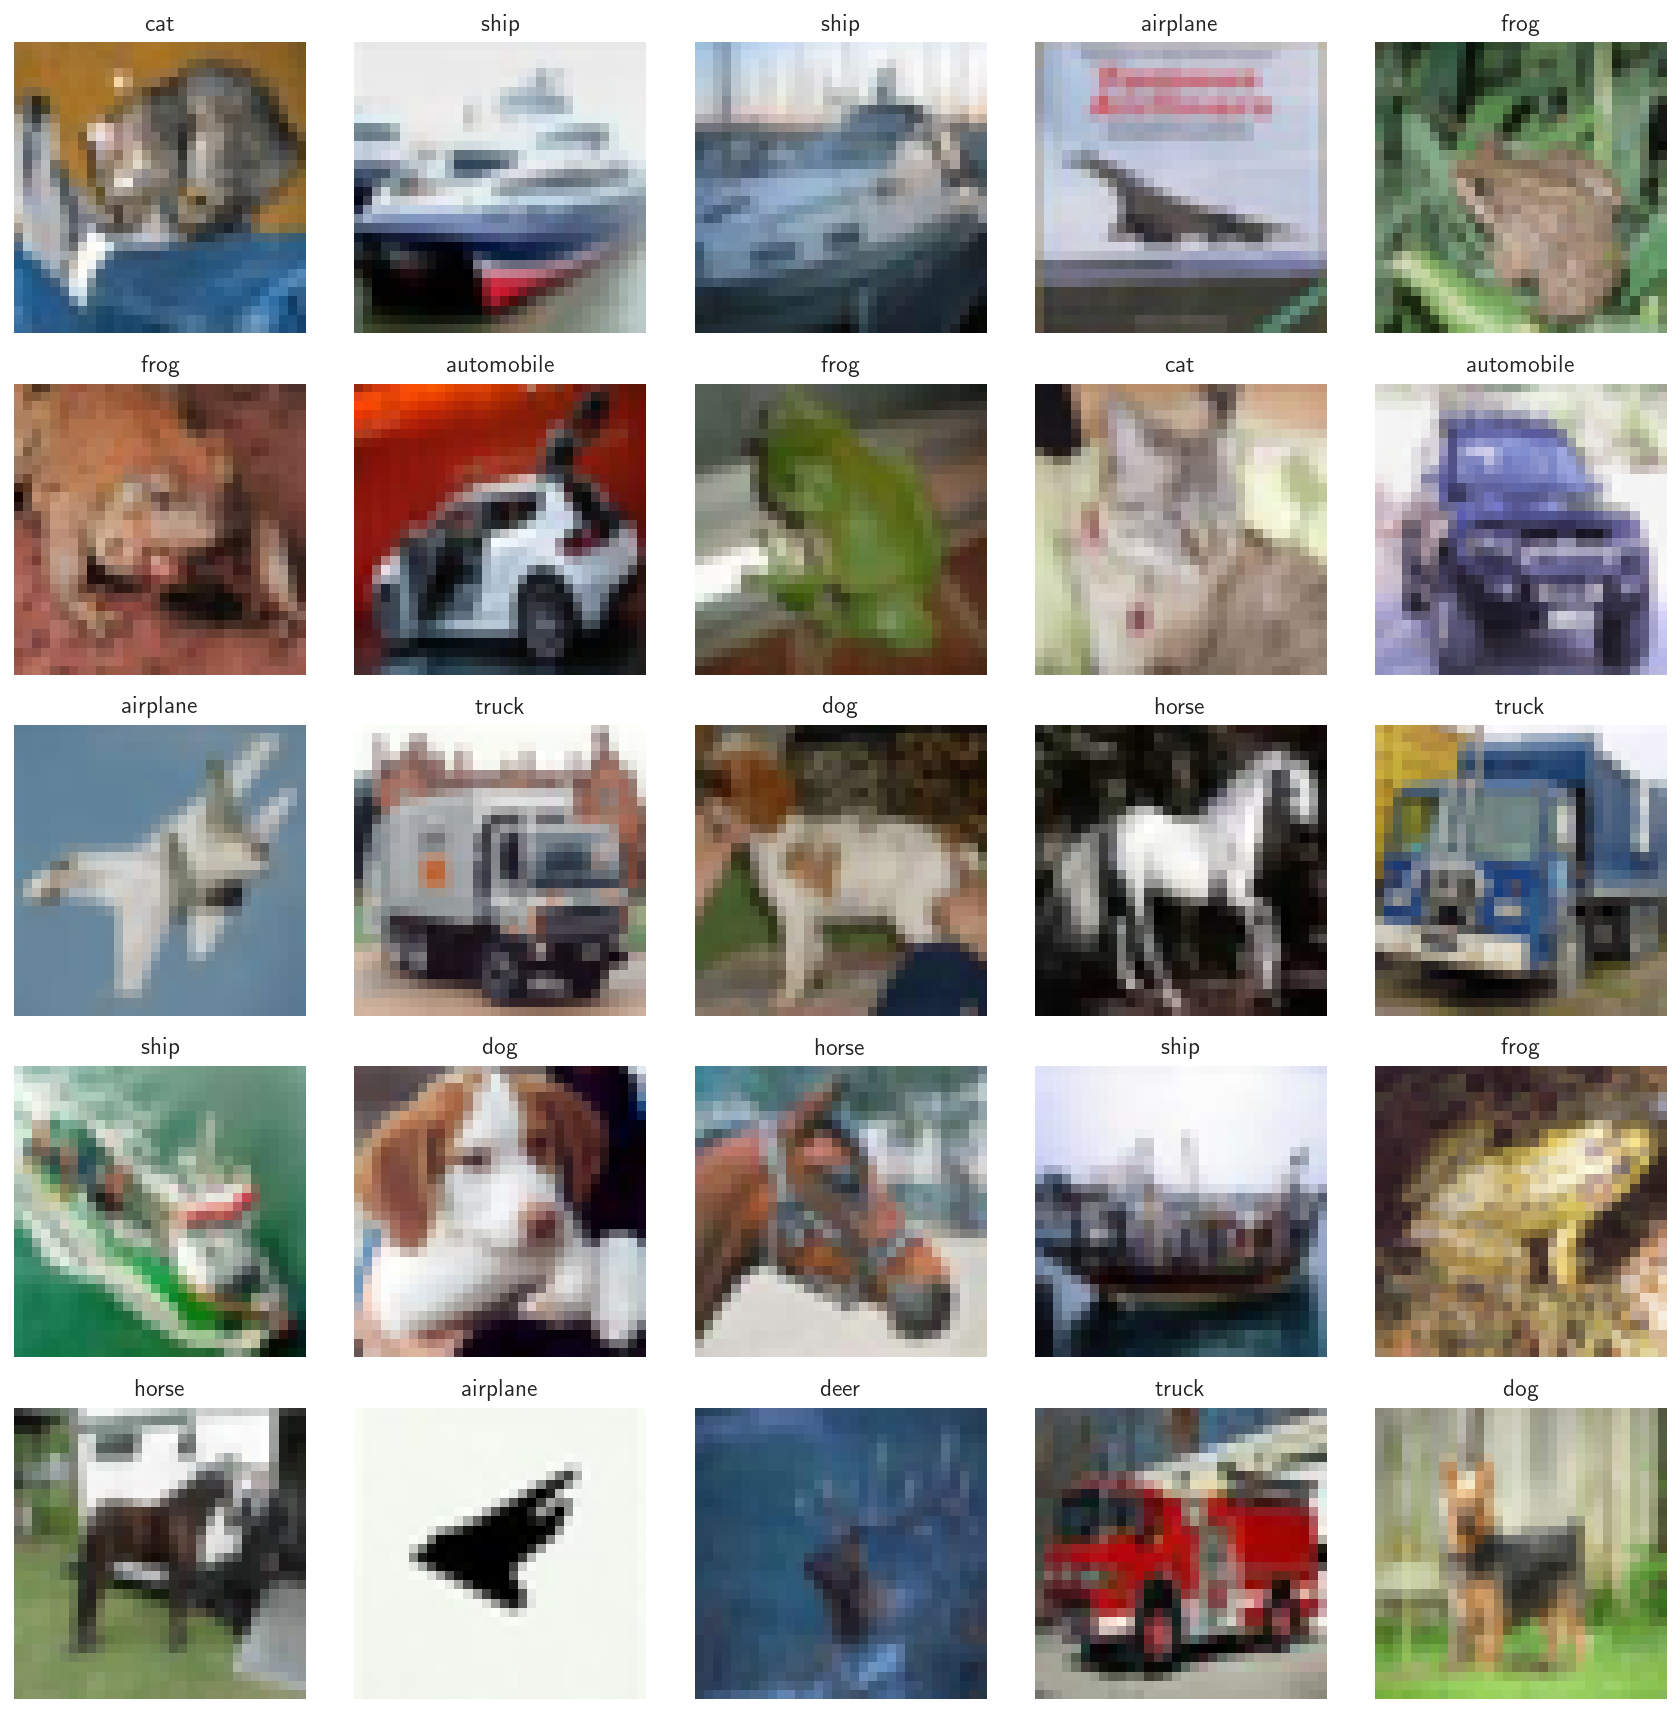

In [2]:
def load(file_name):
    data = []
    
    for file in glob.glob('cifar-10-batches-py/' + file_name):
        with open(file, 'rb') as fo:
            data.append(pickle.load(fo, encoding='bytes'))
            
    images = np.array(data[0][b'data'])
    labels = np.array(data[0][b'labels'])

    if len(data) > 1:
        for i in range(1, len(data)):
            images = np.concatenate((images, data[i][b'data']), axis=0)
            labels = np.concatenate((labels, data[i][b'labels']), axis=0)
    
    return (images.reshape(-1, 3, 32, 32)/255.0).astype(np.float32), labels.reshape((-1, 1))


Xtrain, Ttrain = load('data_batch_*')
Xtest, Ttest, = load('test_batch')

print(Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape)
    
with open('cifar-10-batches-py/batches.meta', 'rb') as f:
    class_names = pickle.load(f, encoding='bytes')
class_names = class_names[b'label_names']
classes = np.unique(Ttrain)
    
def imshow(Xset, Tset):
    plt.figure(figsize=(12, 12))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(np.moveaxis(Xset[i,...], 0, 2), interpolation='nearest')
        plt.axis('off')
        unicode = class_names[Tset[i][0]].decode('utf-8')
        plt.title(unicode) 

    plt.tight_layout()
    
imshow(Xtest, Ttest)

FloatProgress(value=0.0, max=1000.0)

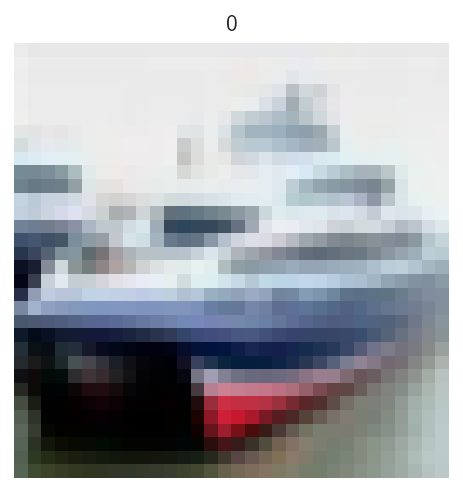

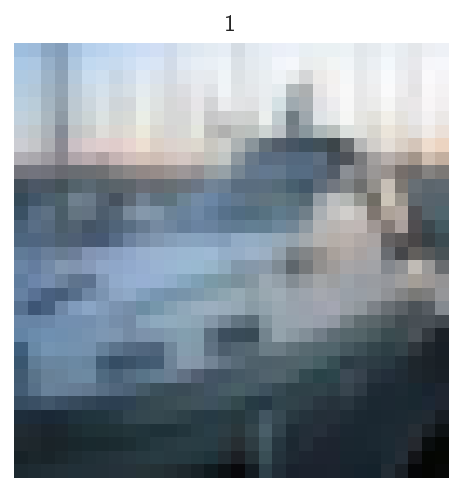

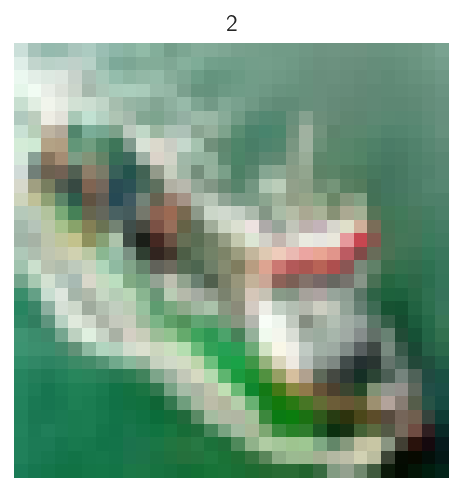

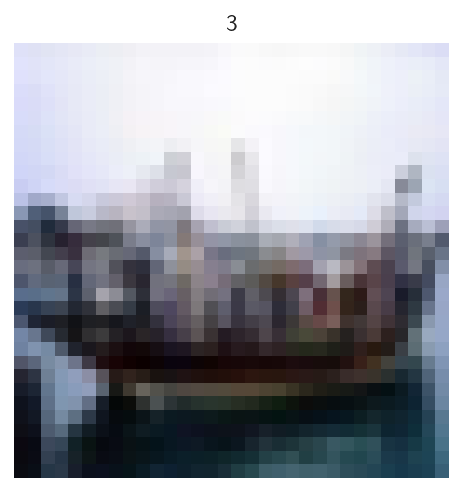

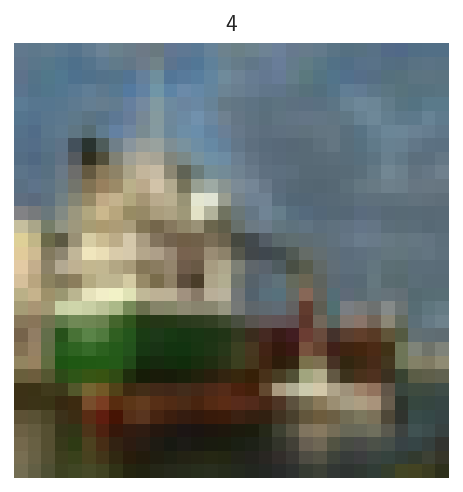

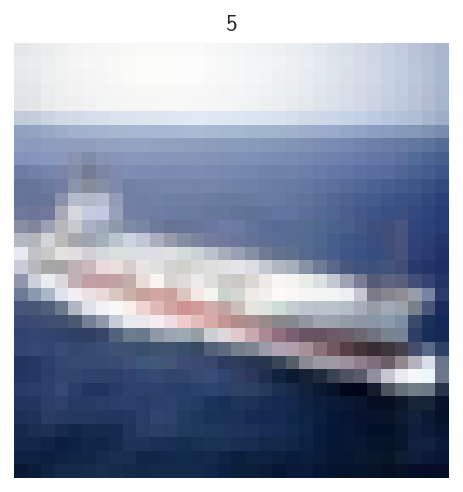

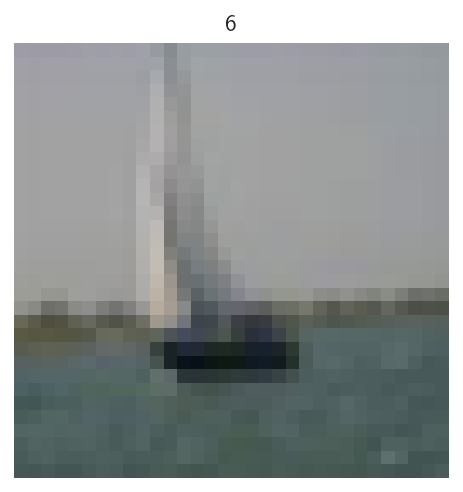

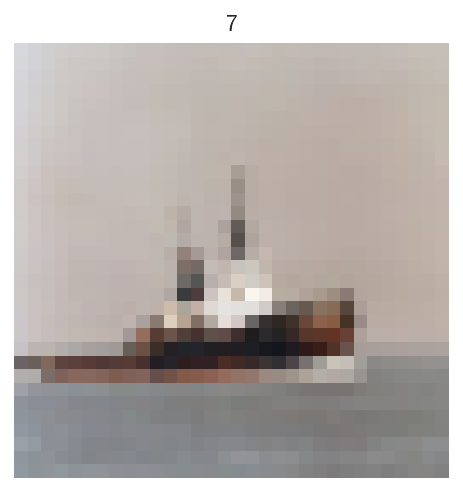

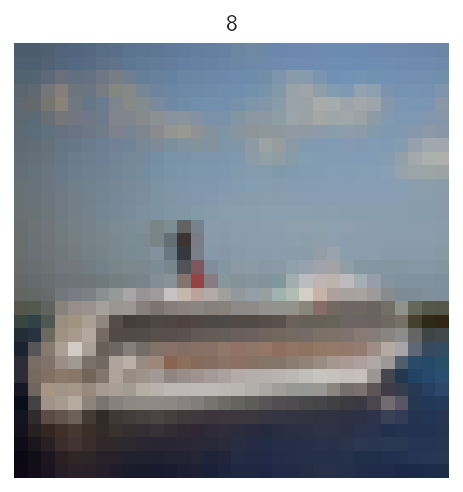

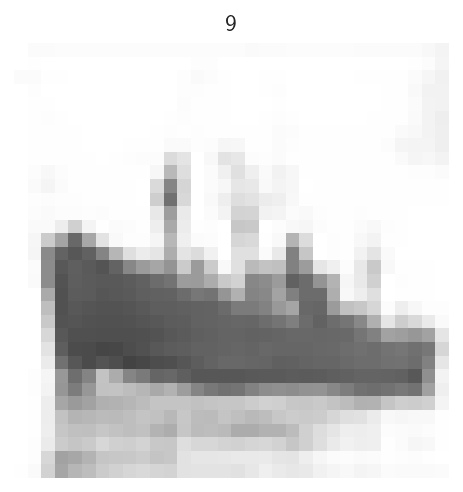

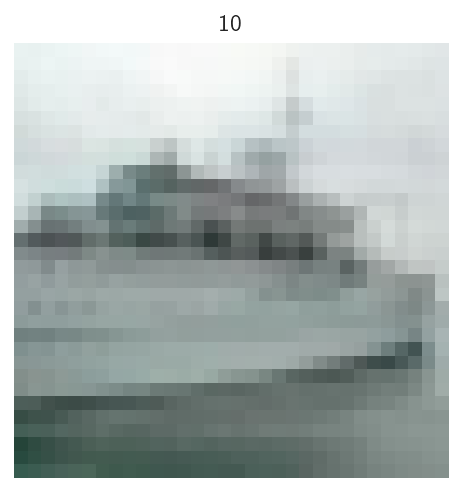

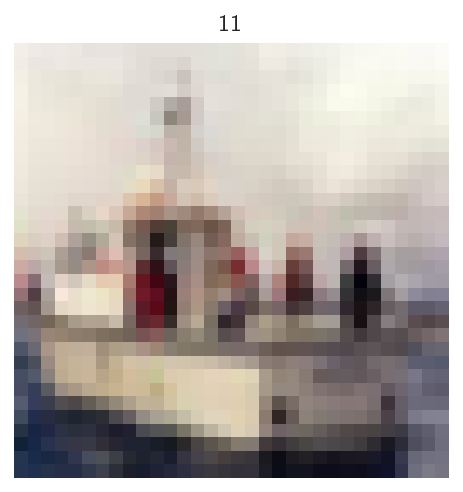

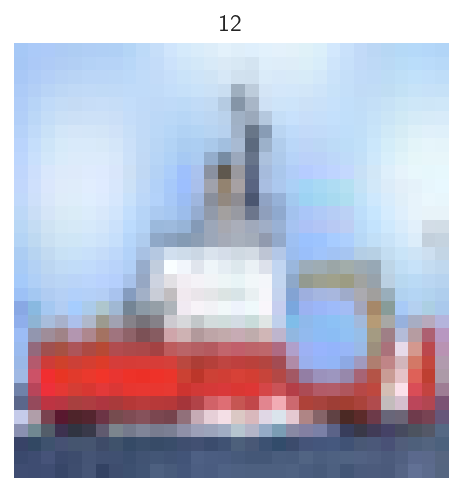

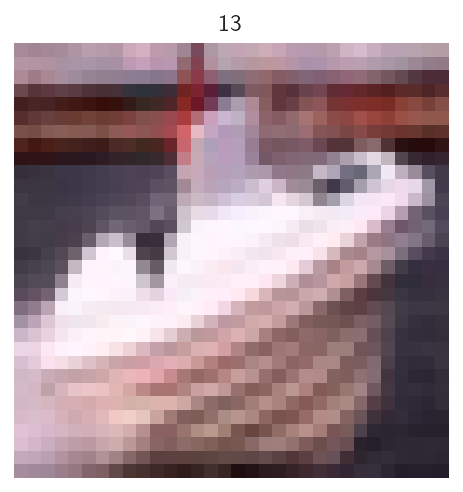

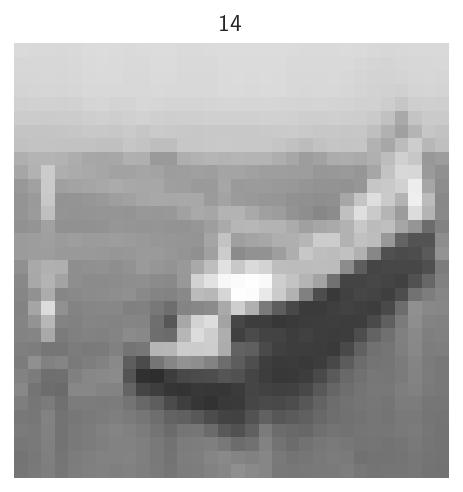

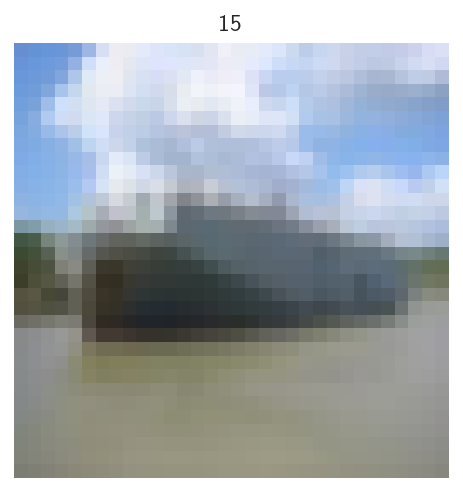

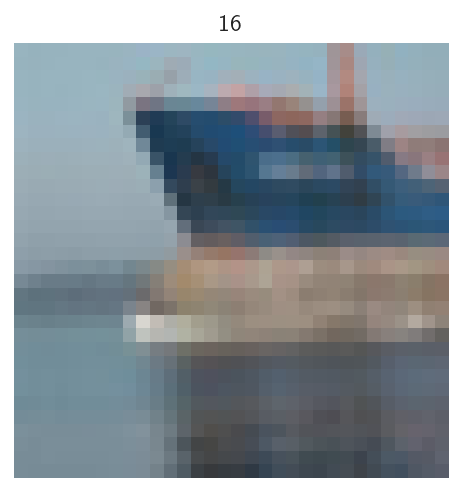

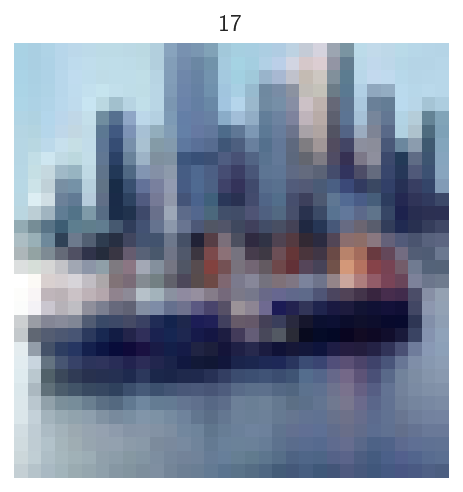

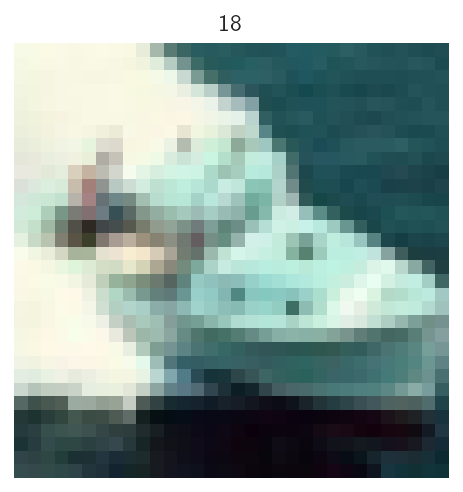

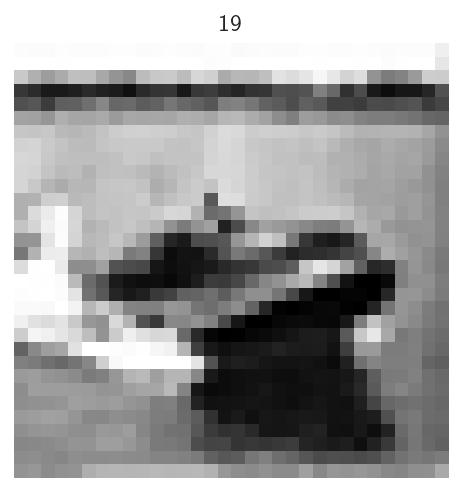

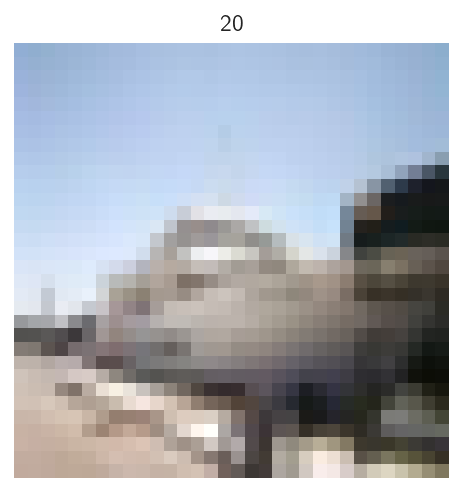

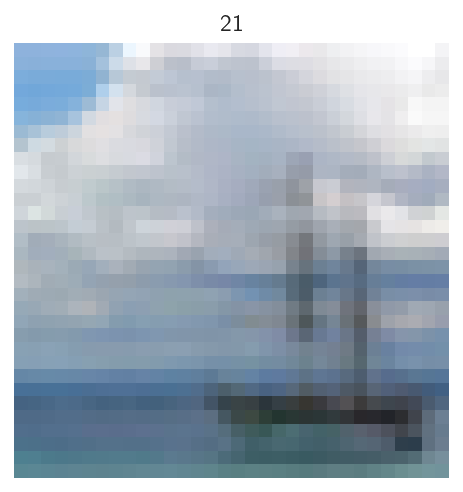

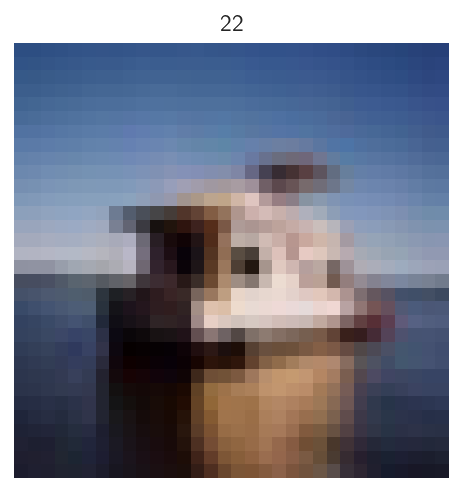

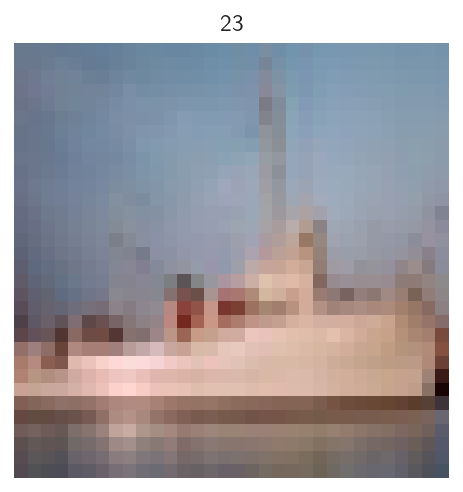

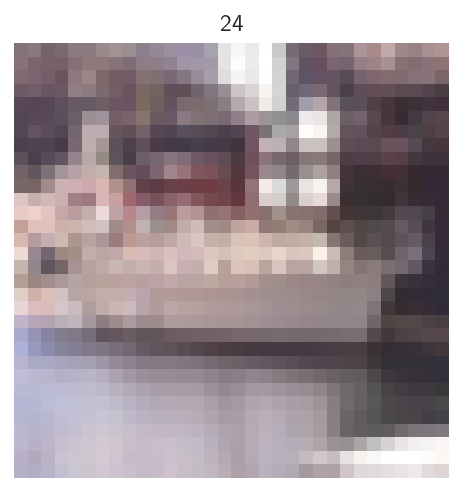

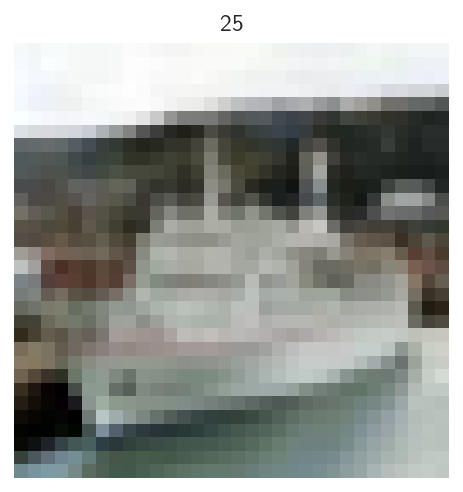

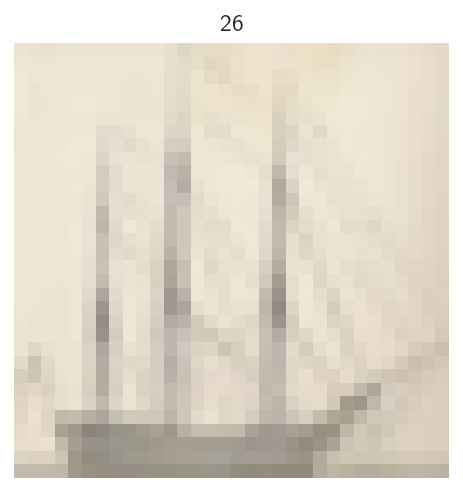

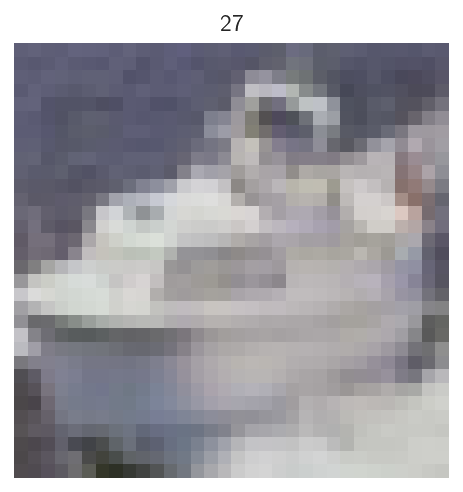

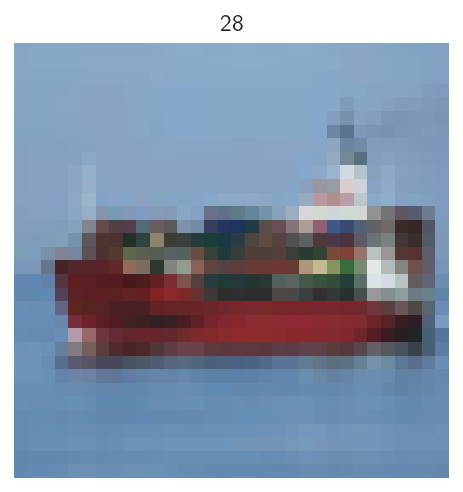

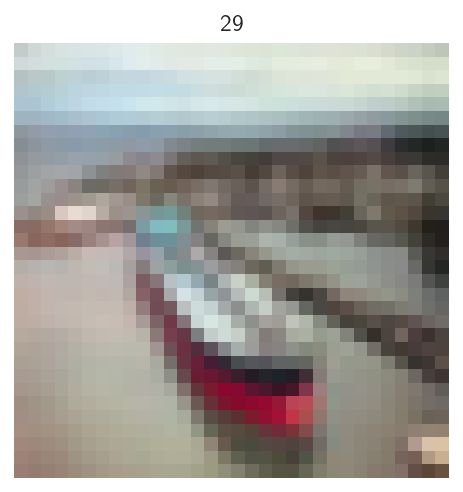

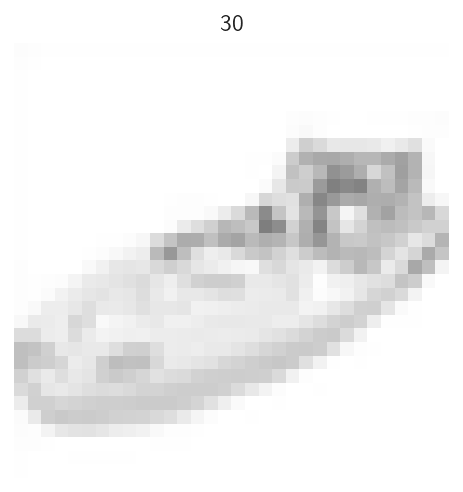

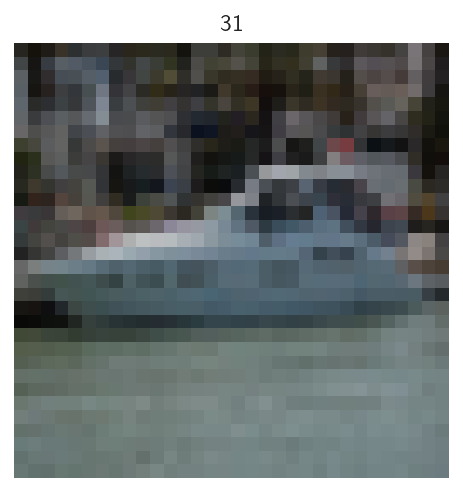

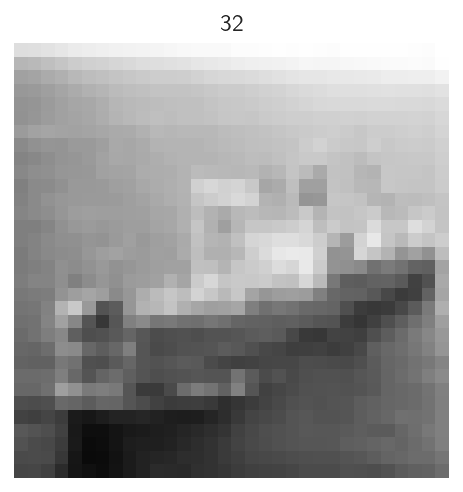

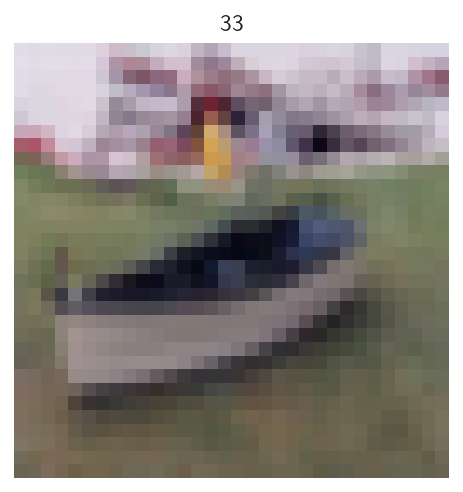

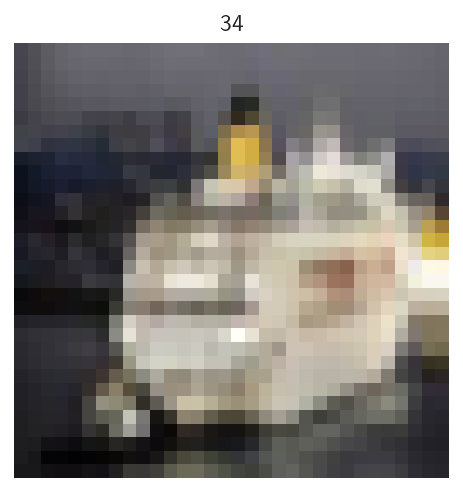

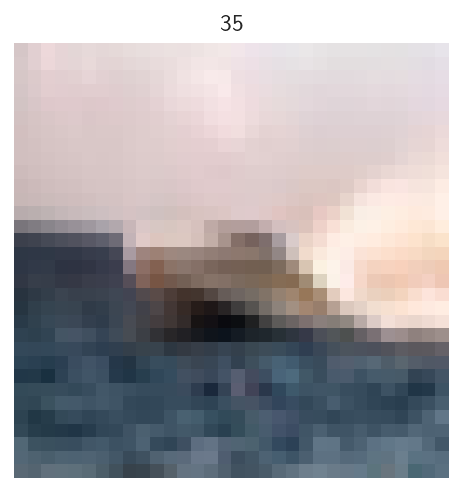

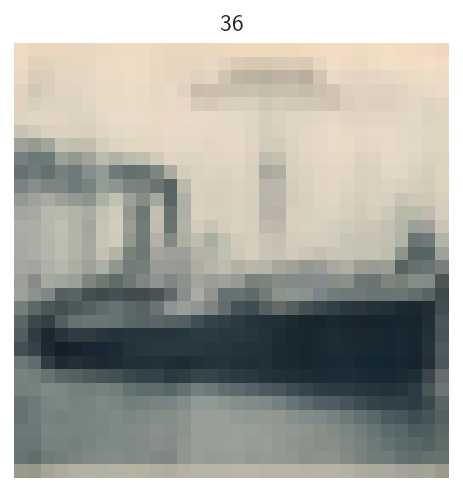

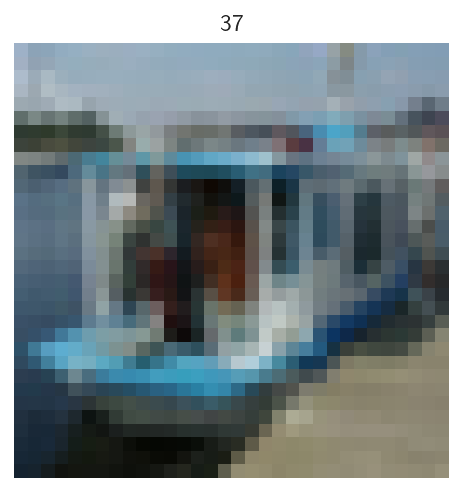

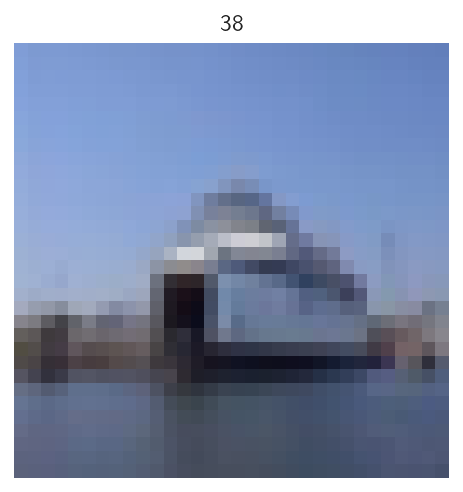

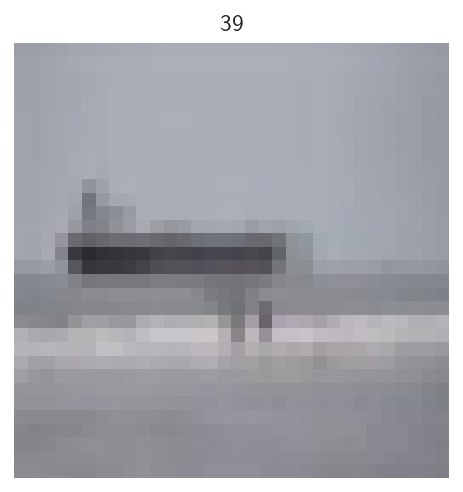

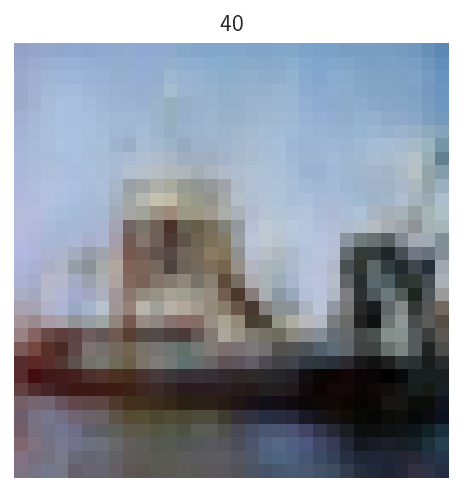

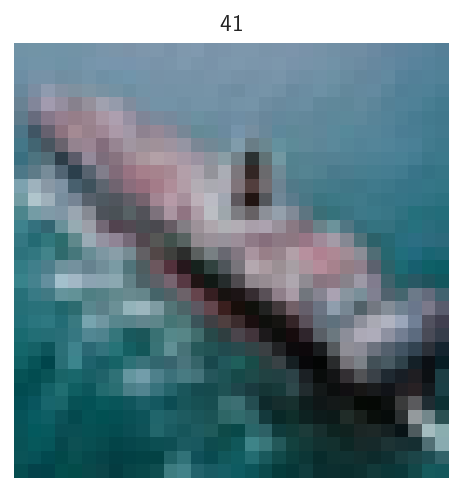

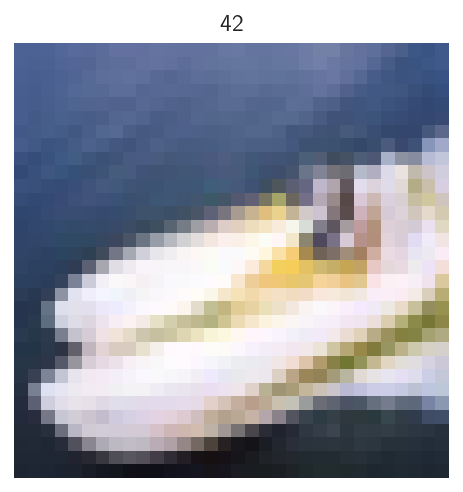

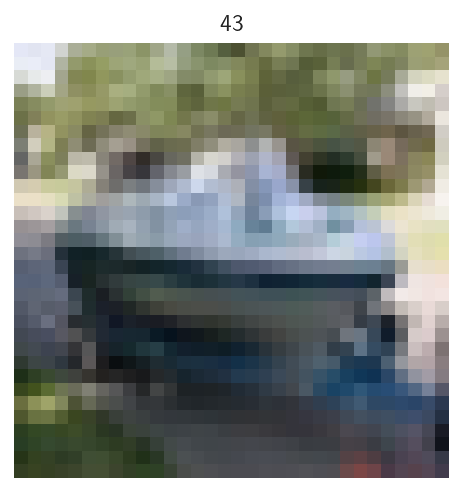

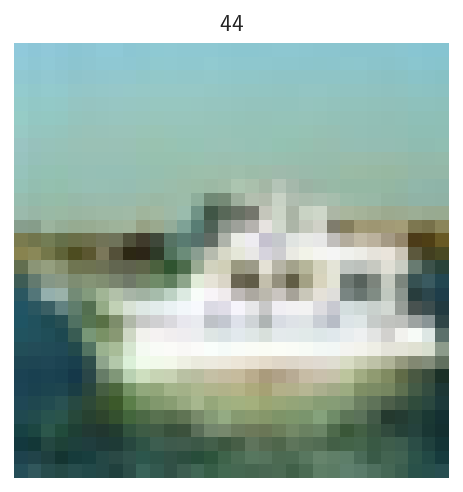

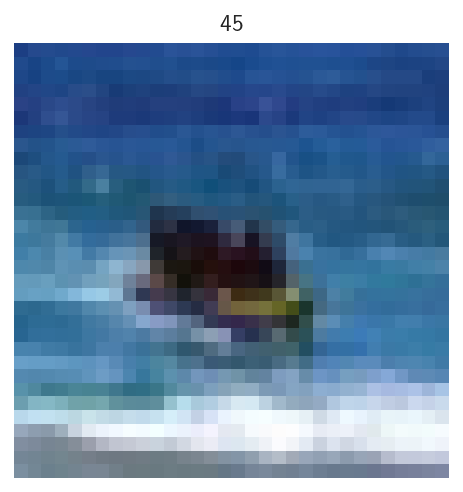

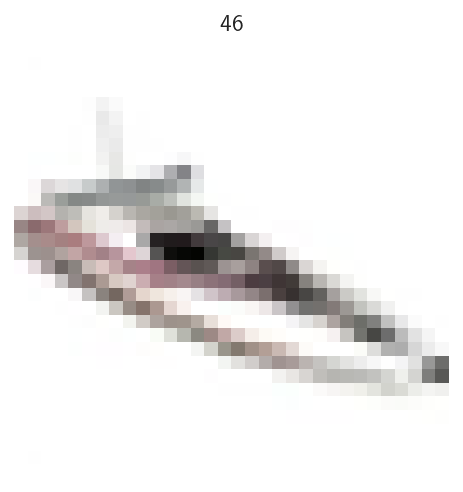

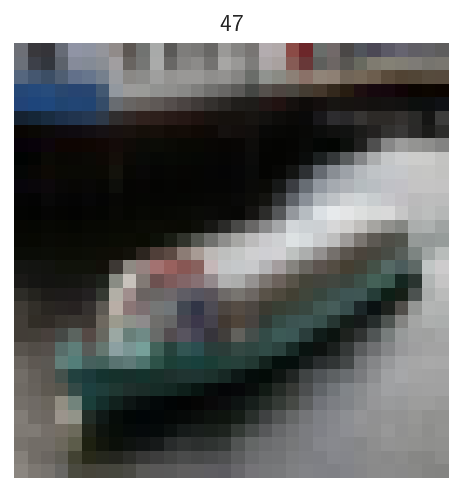

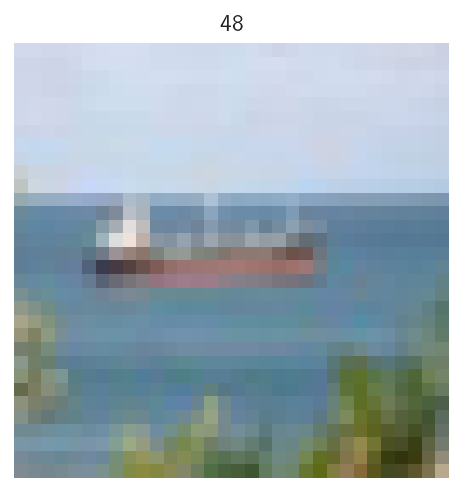

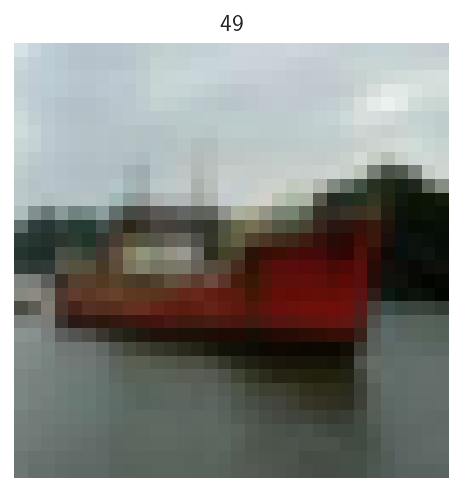

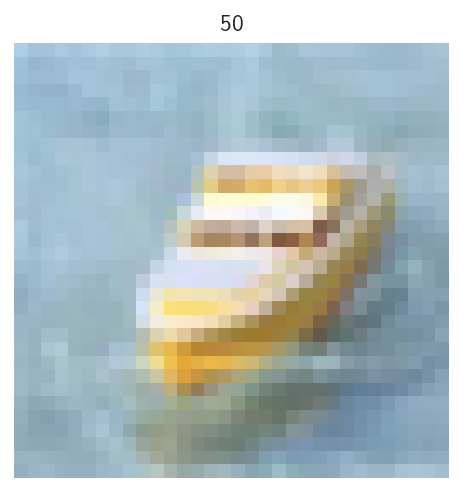

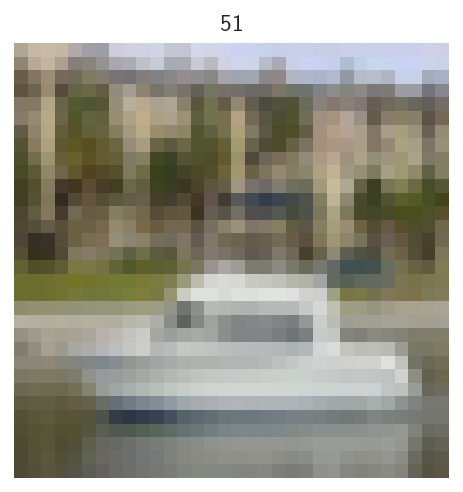

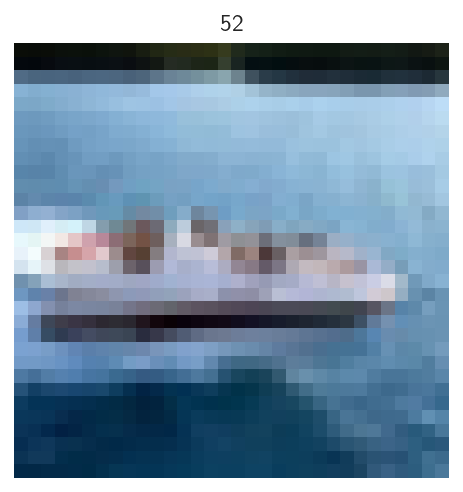

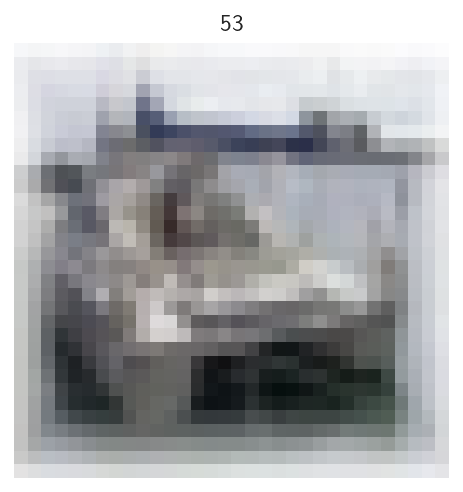

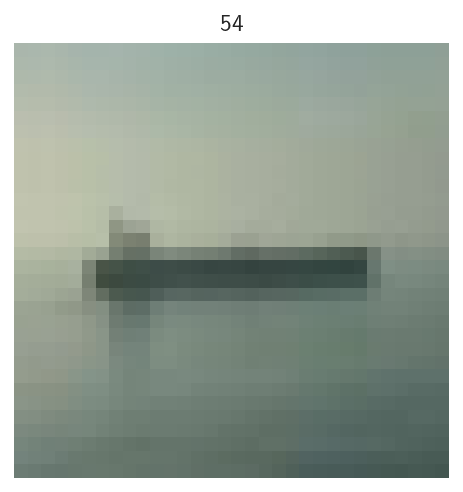

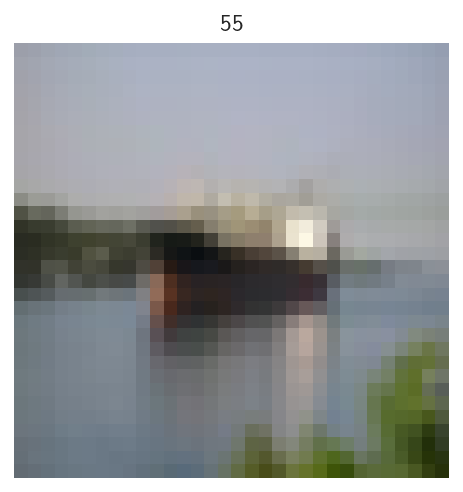

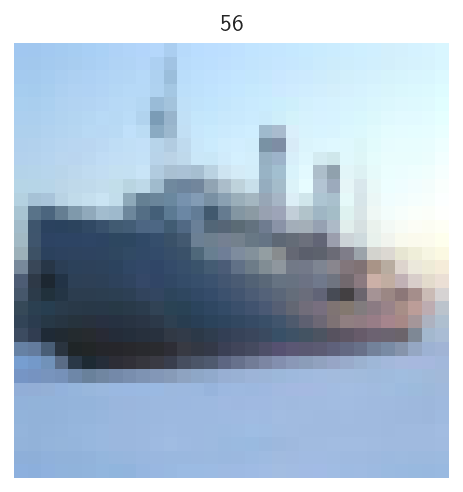

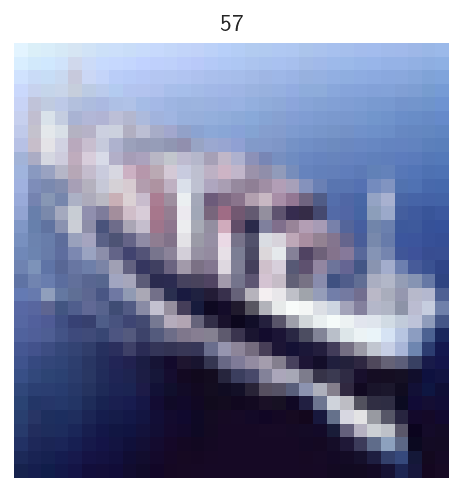

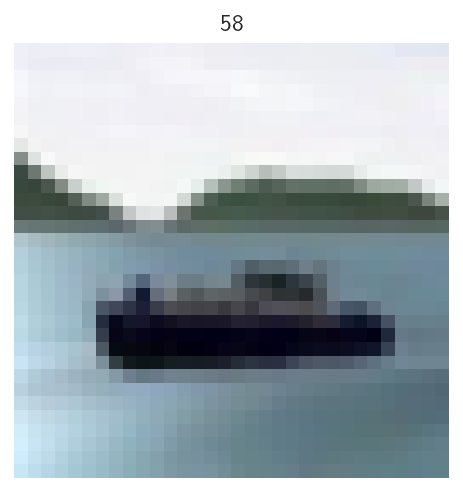

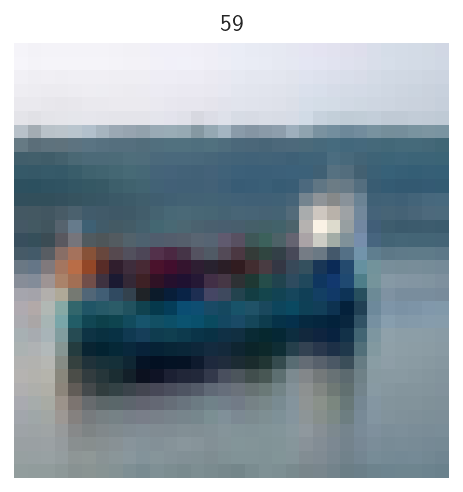

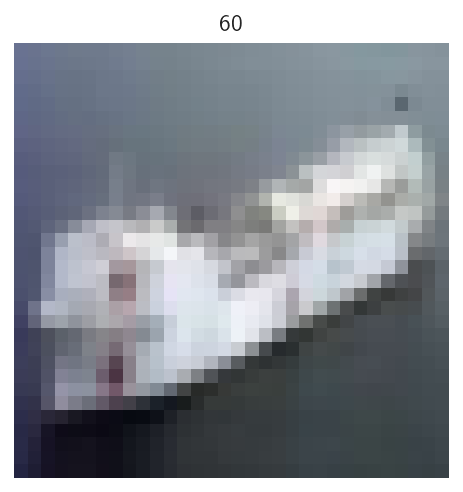

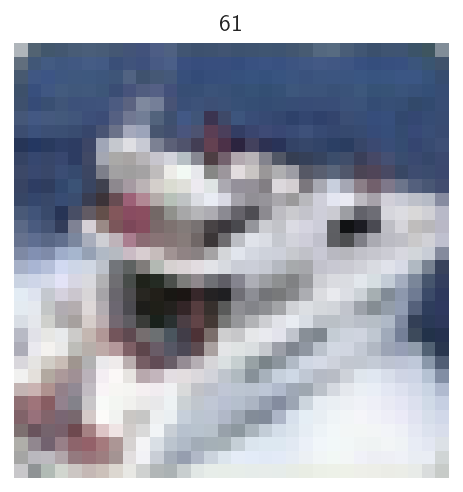

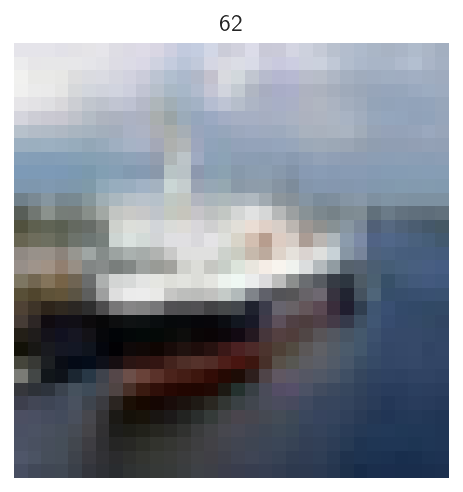

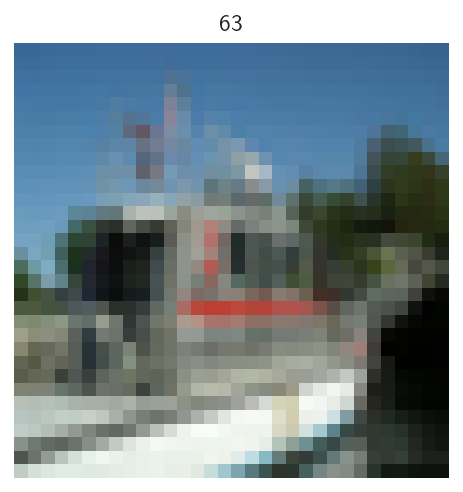

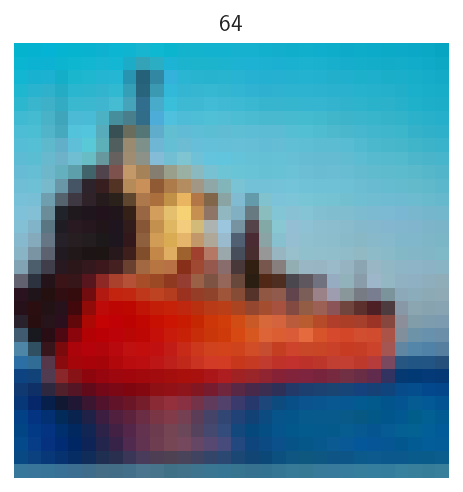

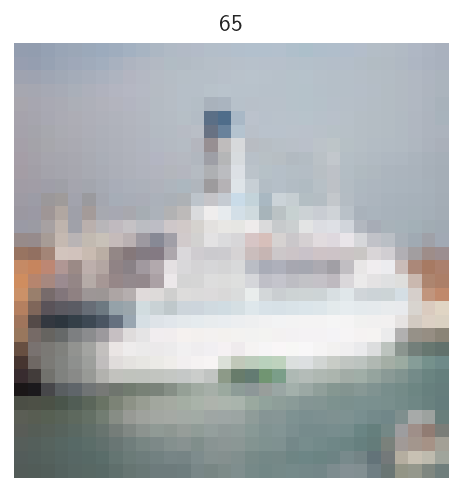

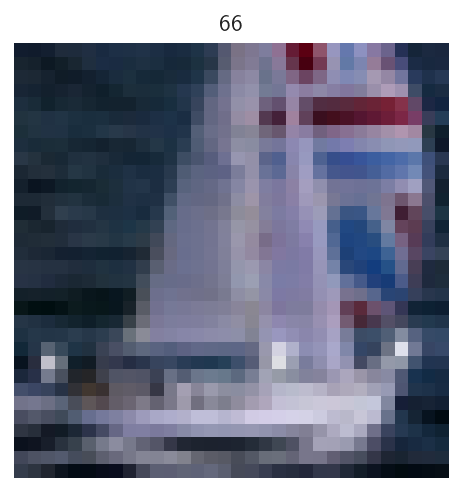

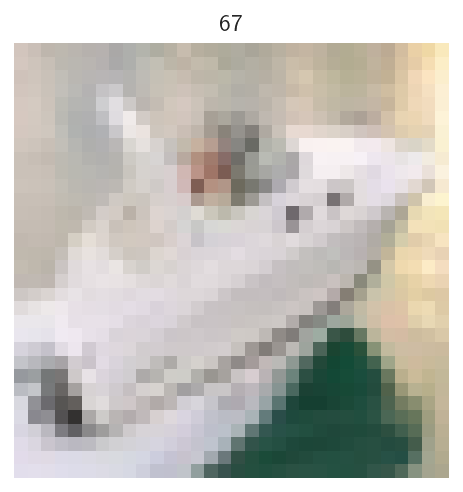

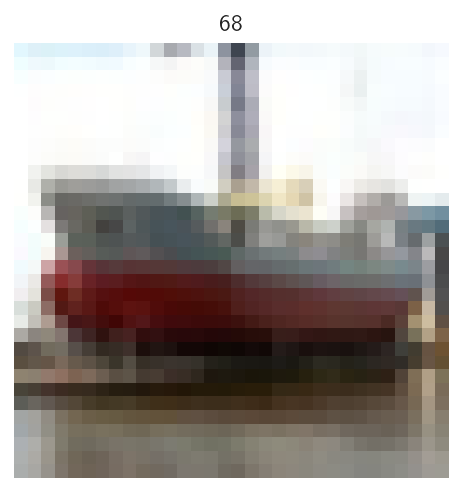

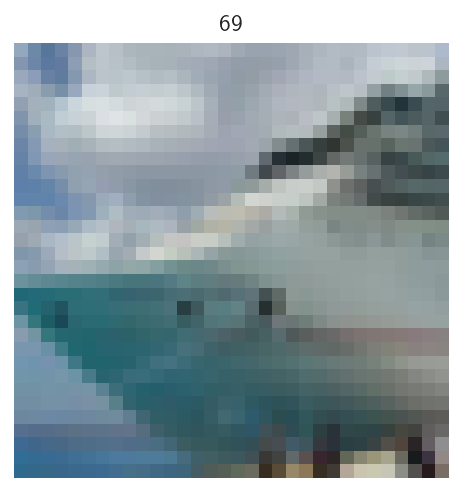

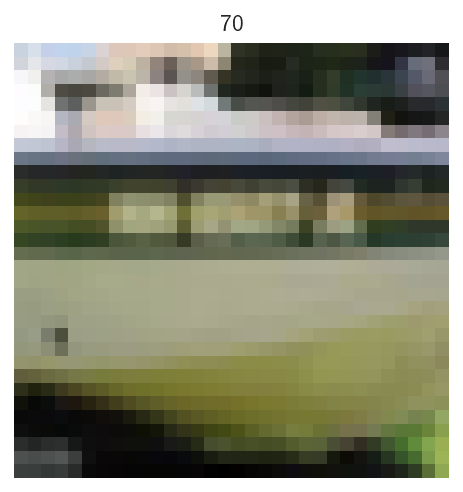

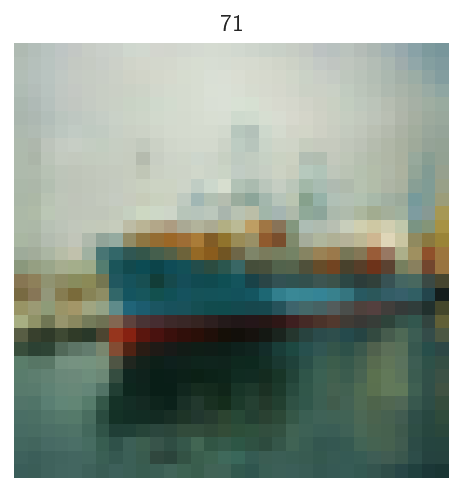

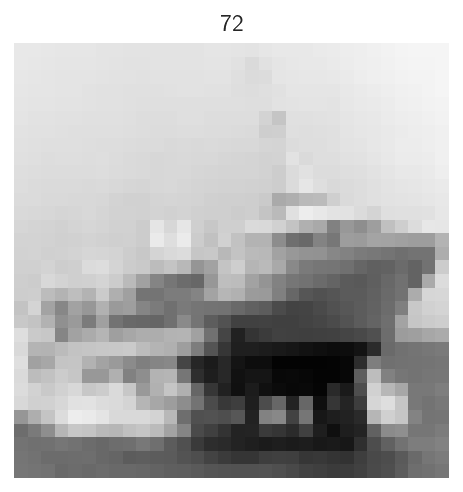

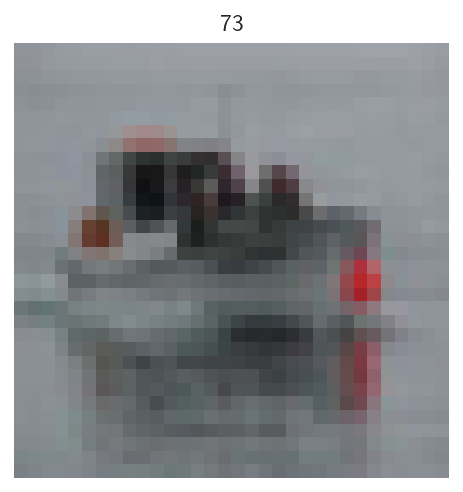

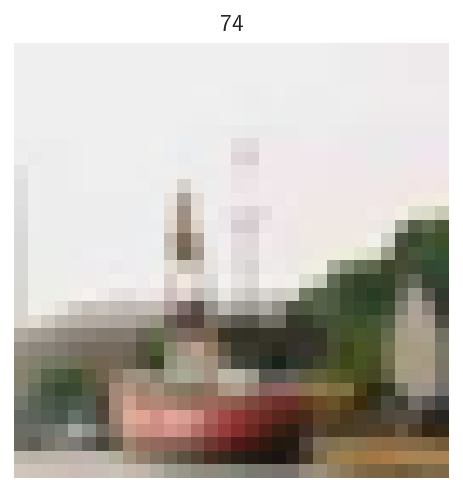

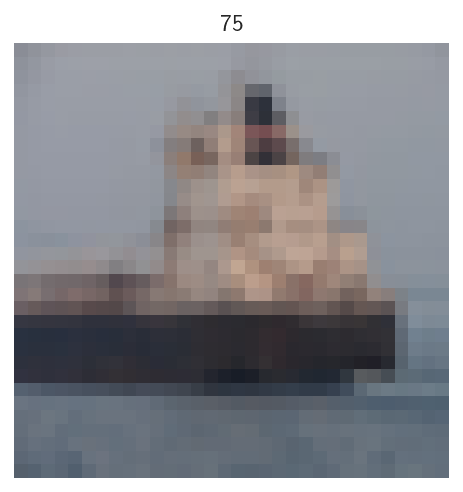

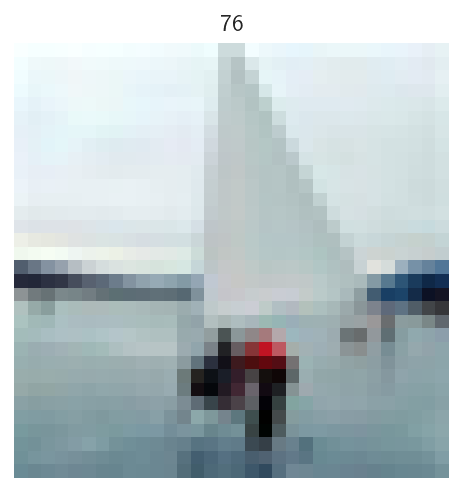

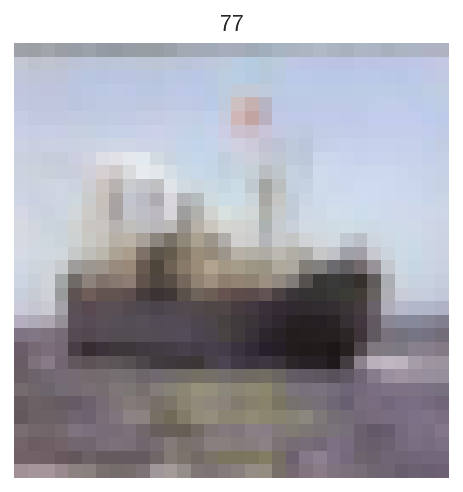

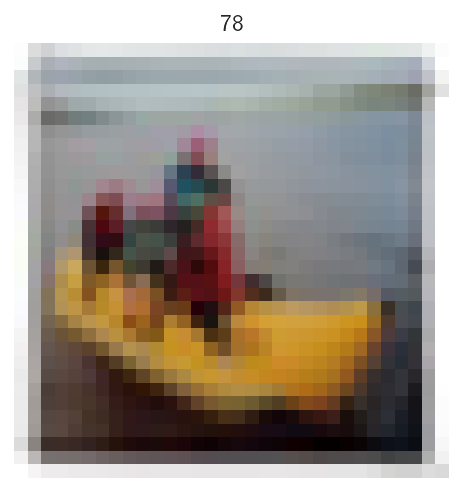

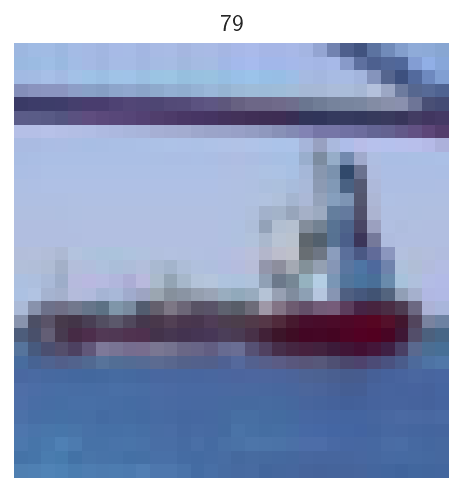

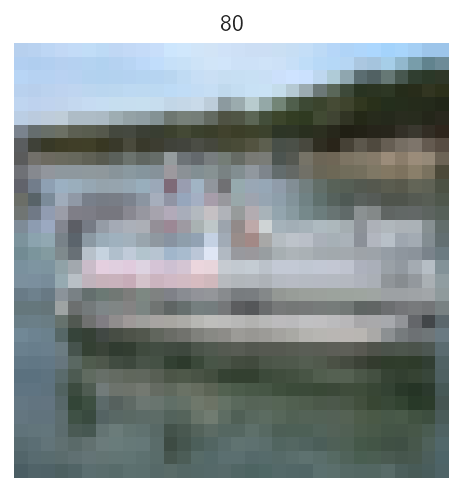

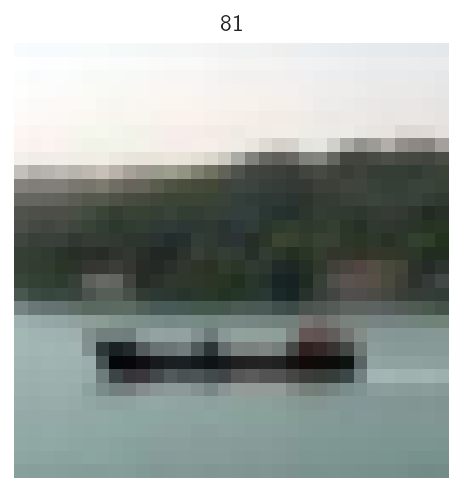

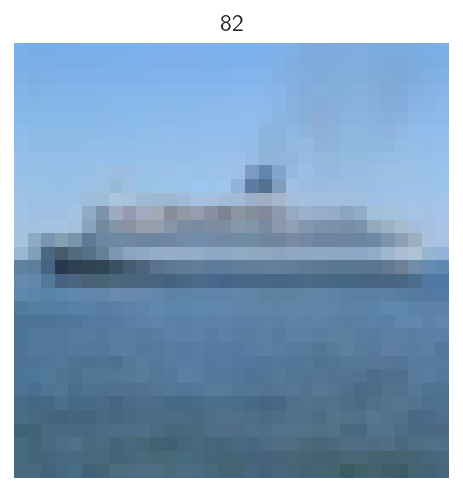

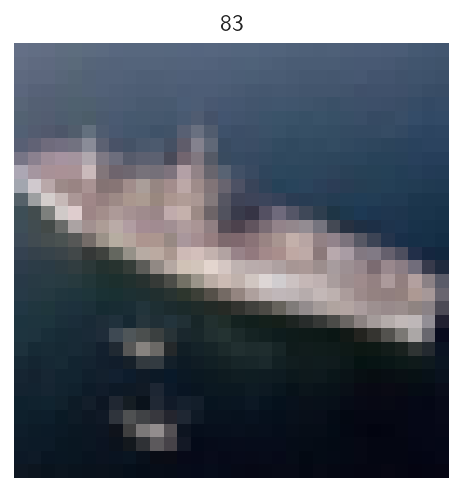

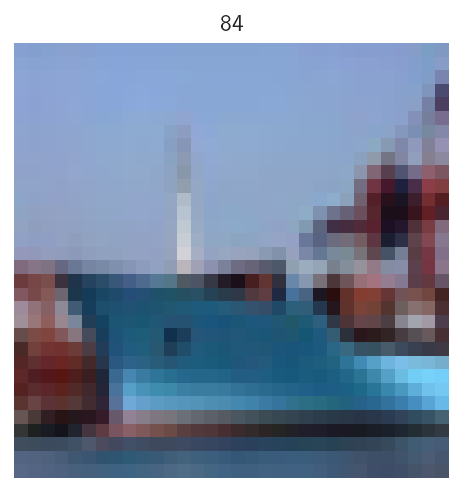

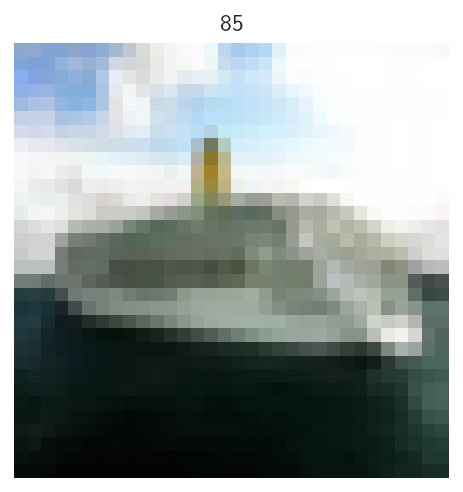

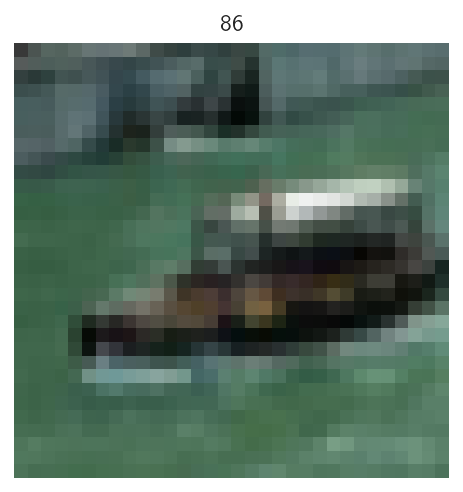

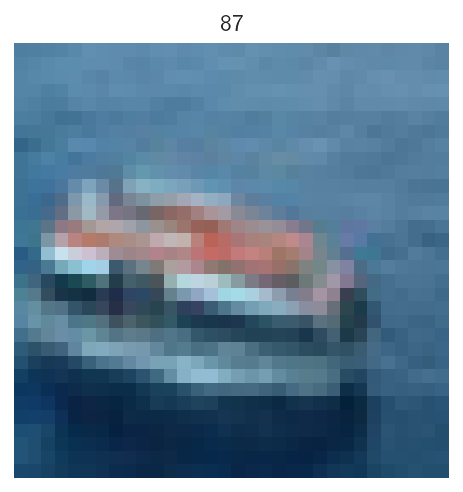

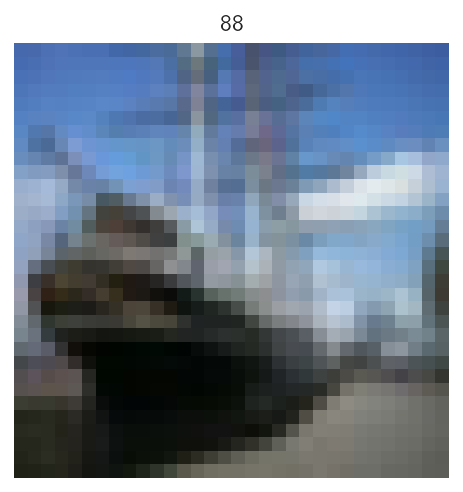

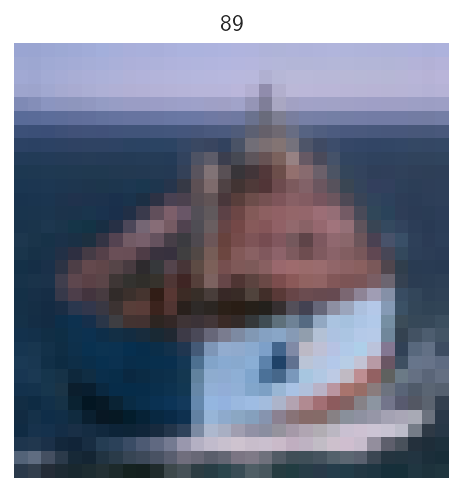

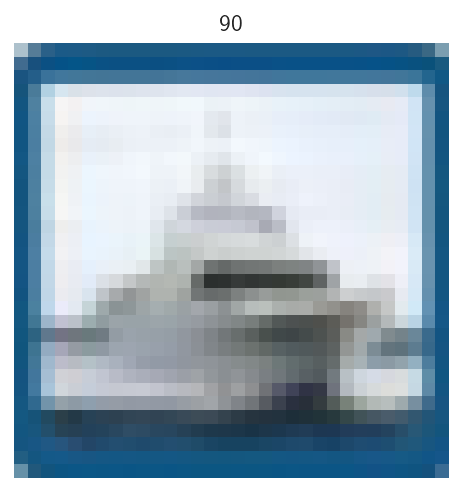

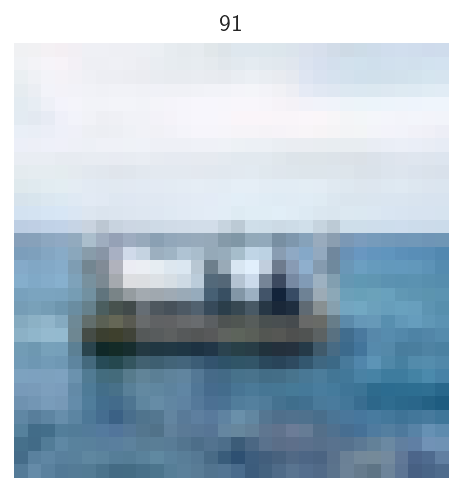

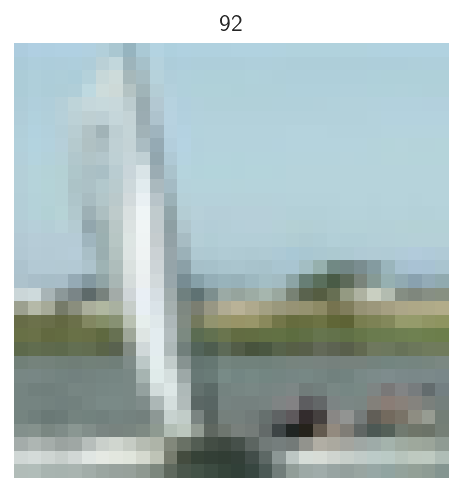

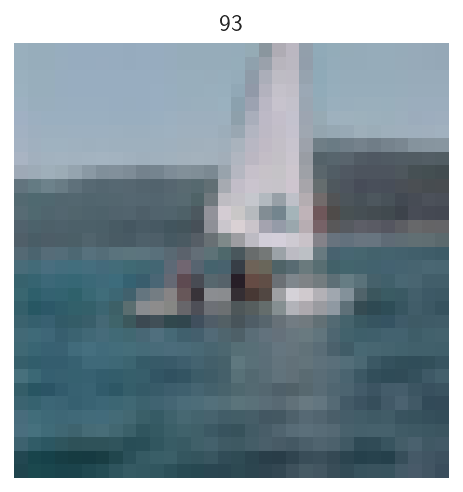

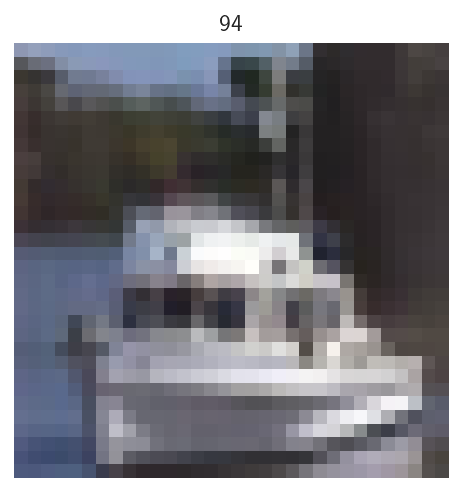

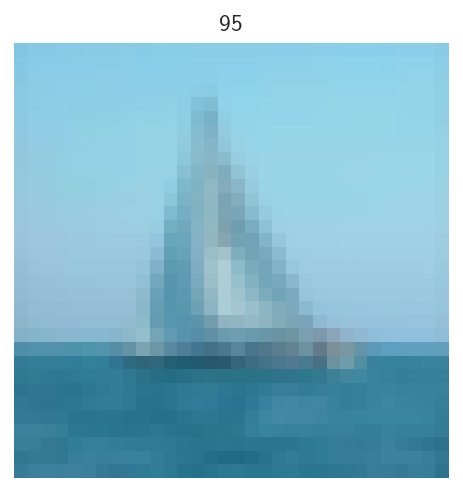

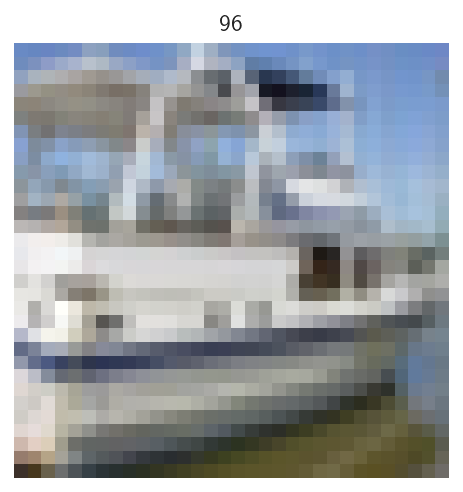

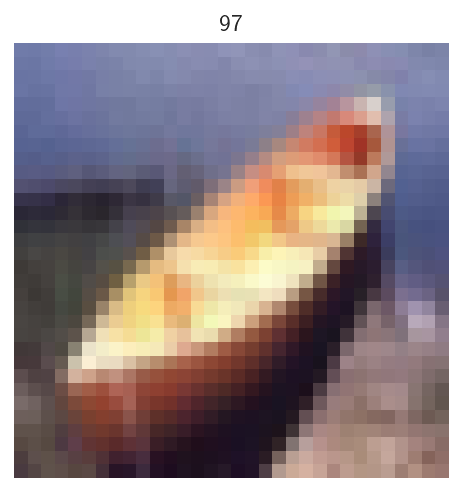

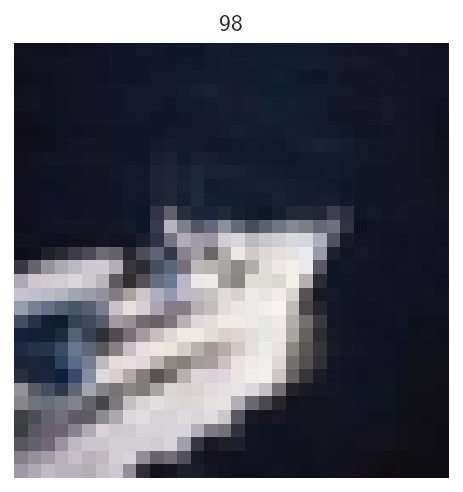

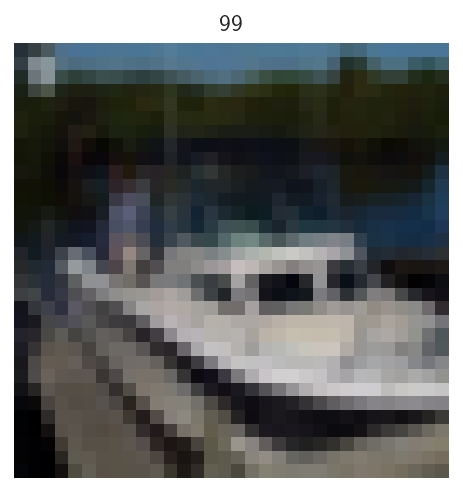

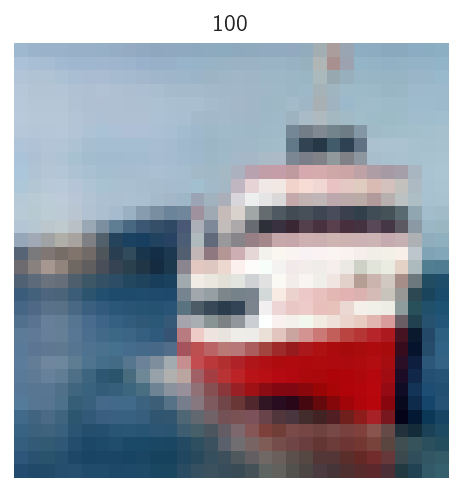

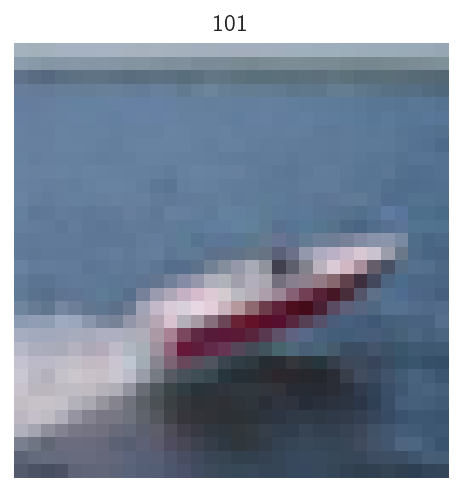

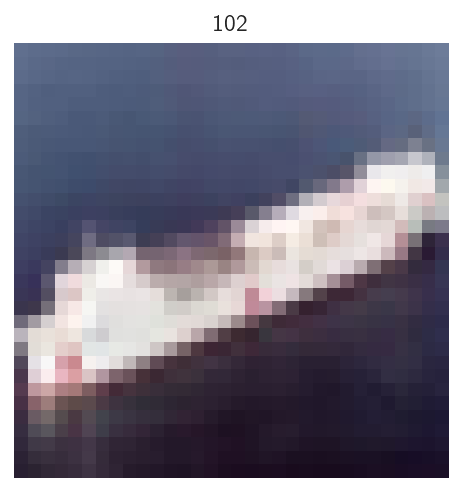

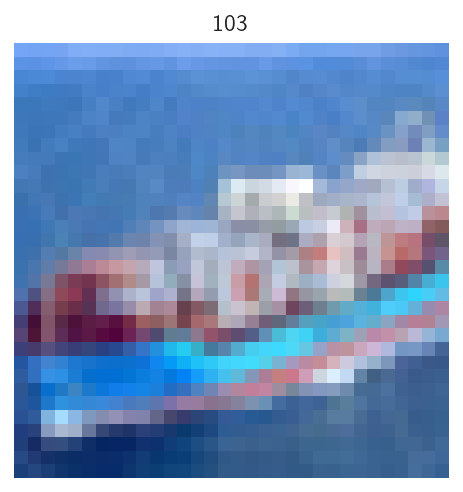

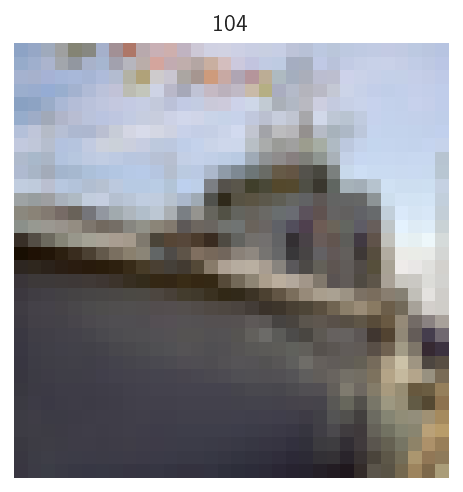

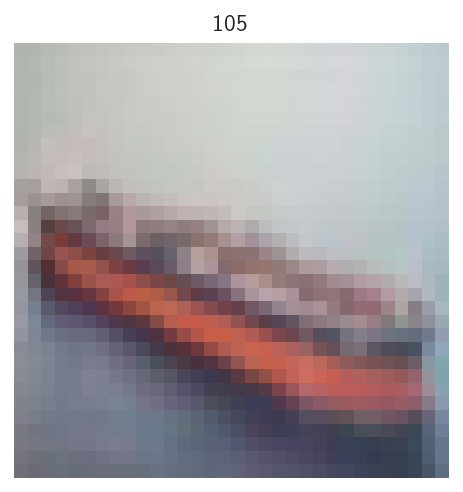

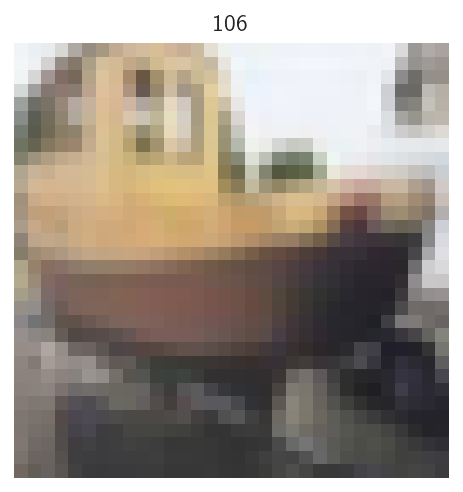

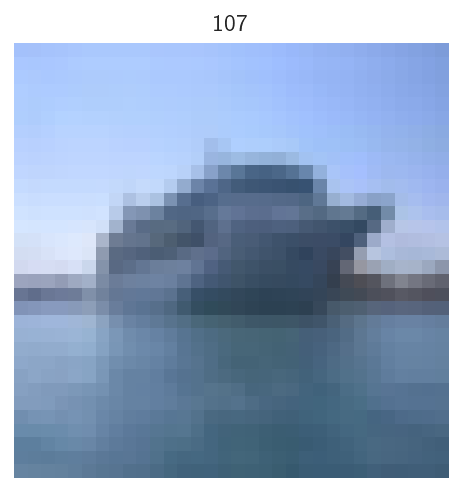

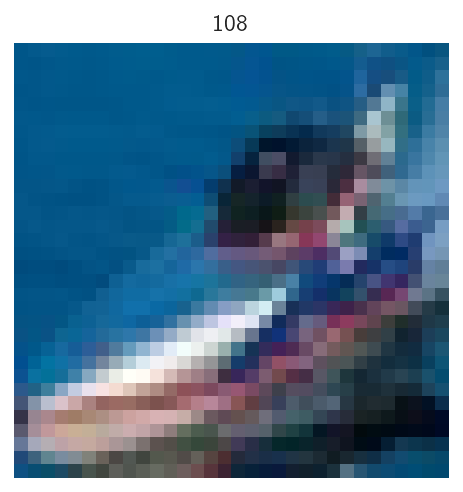

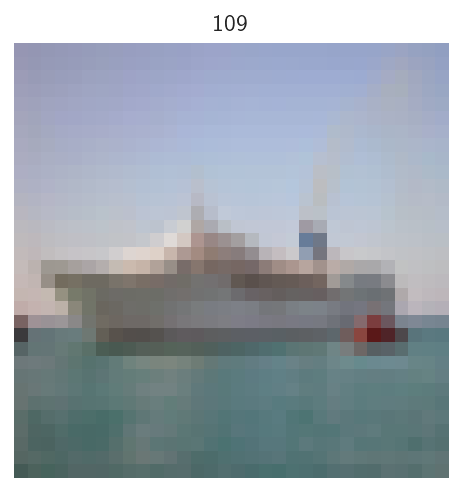

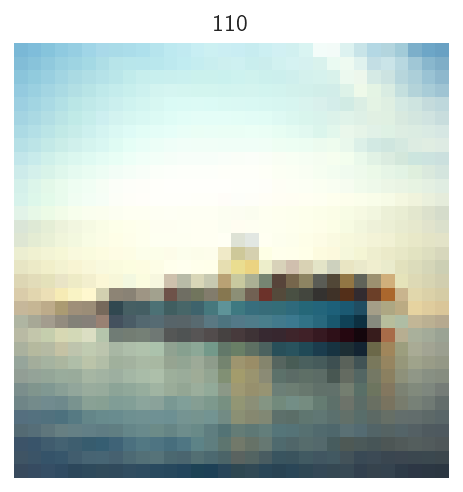

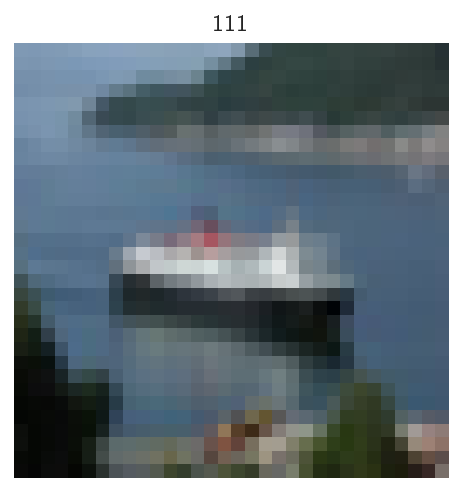

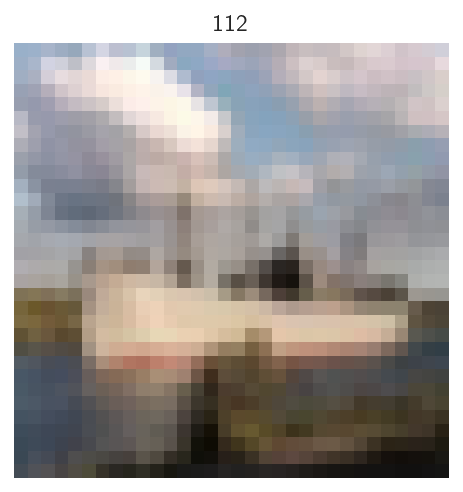

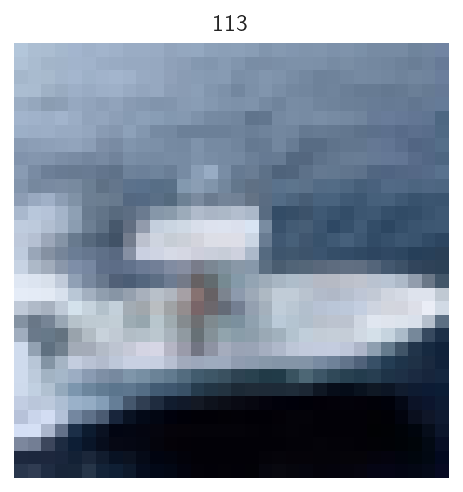

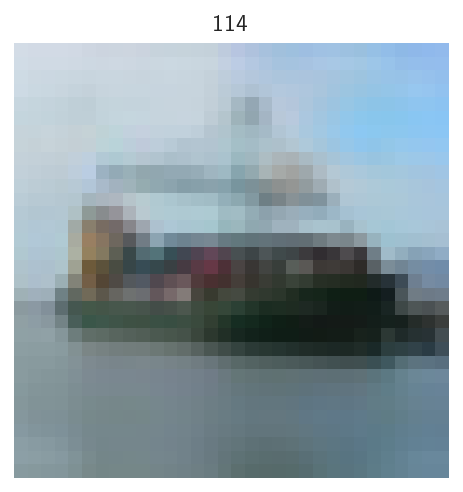

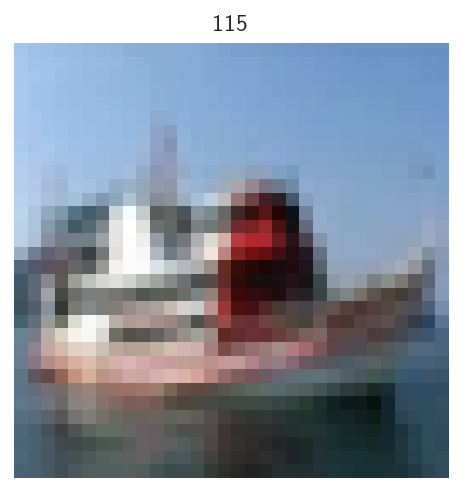

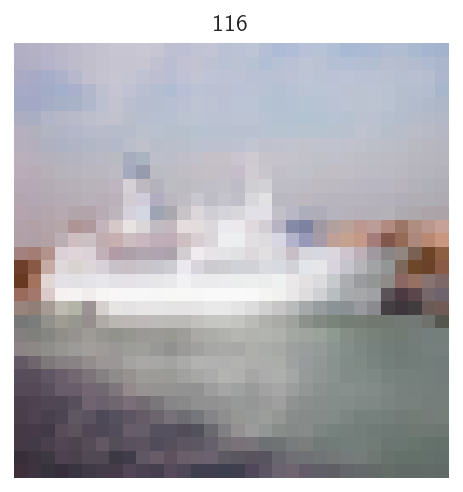

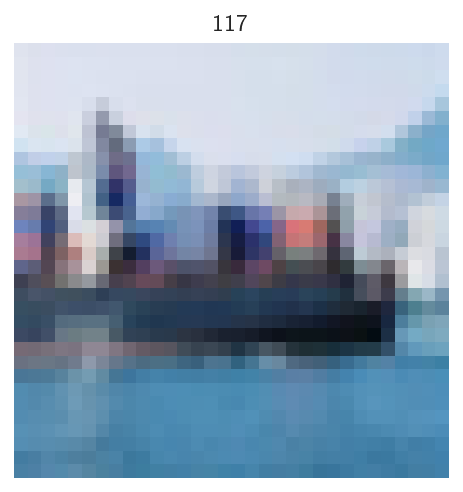

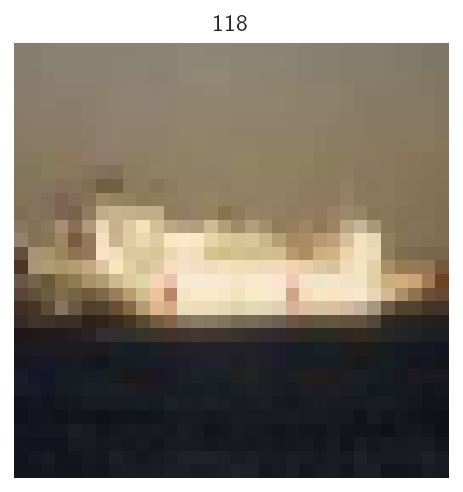

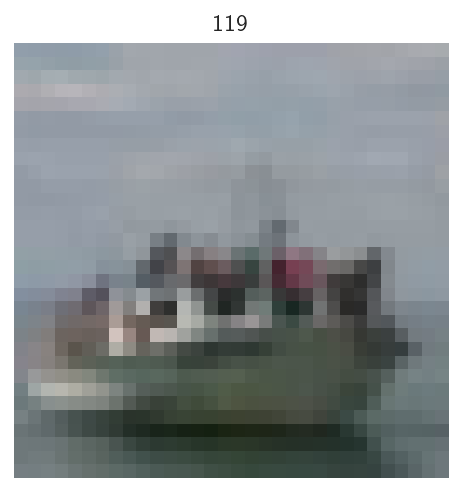

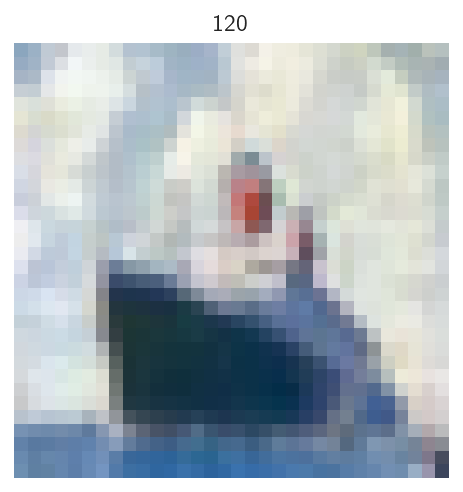

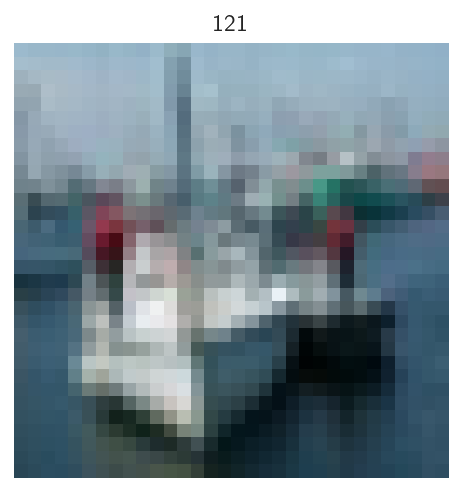

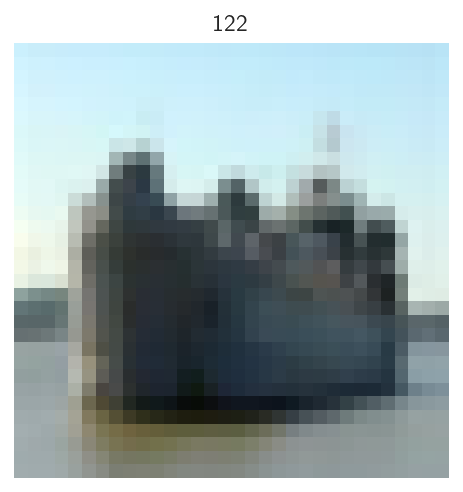

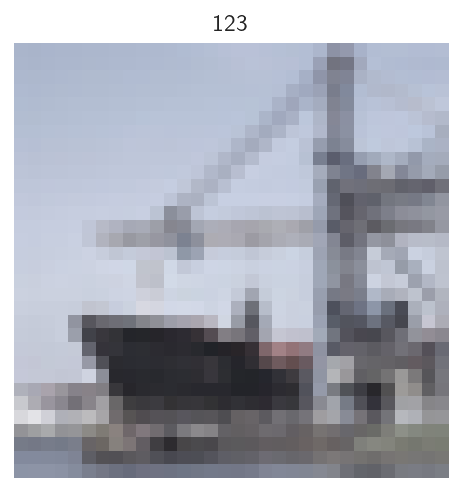

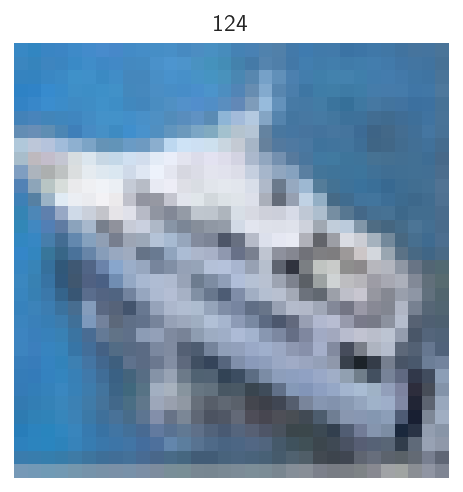

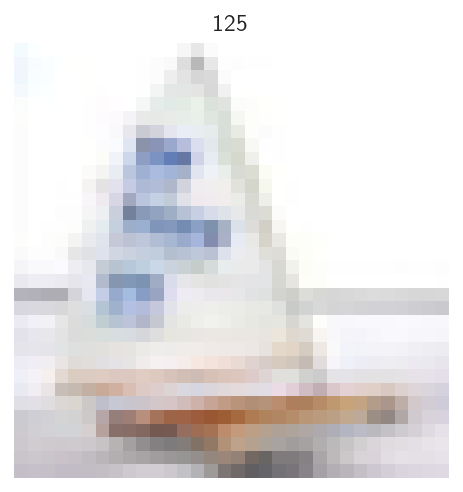

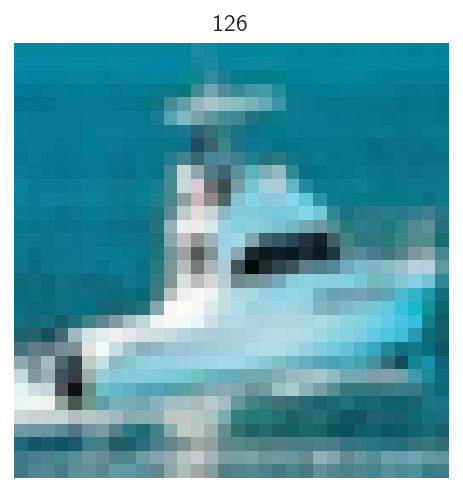

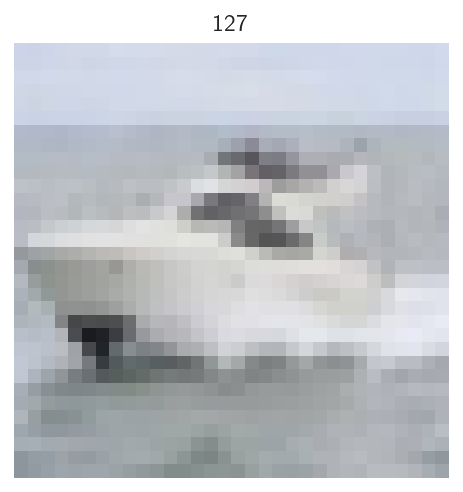

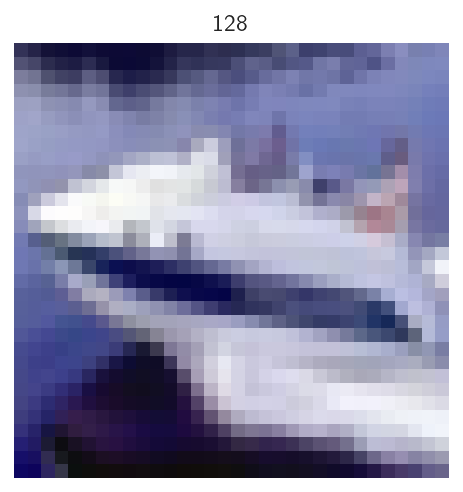

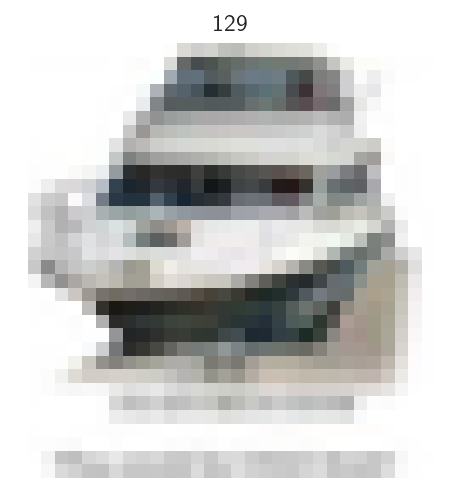

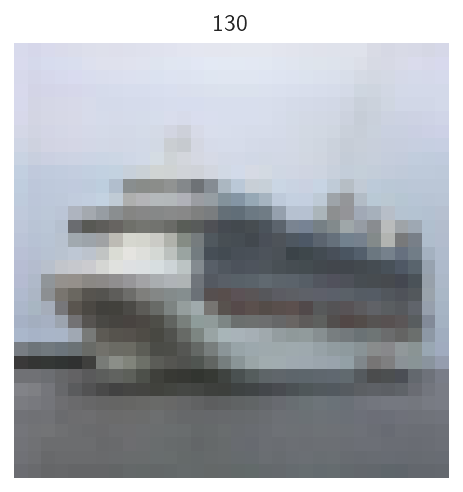

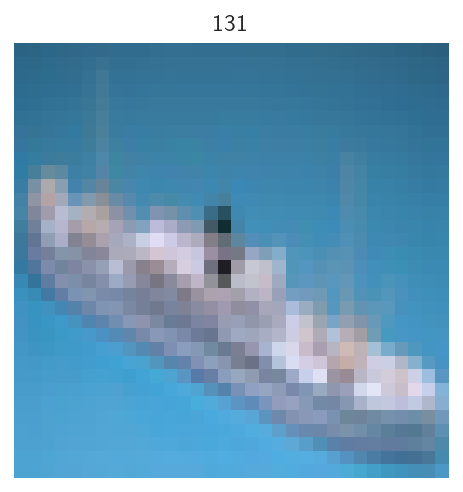

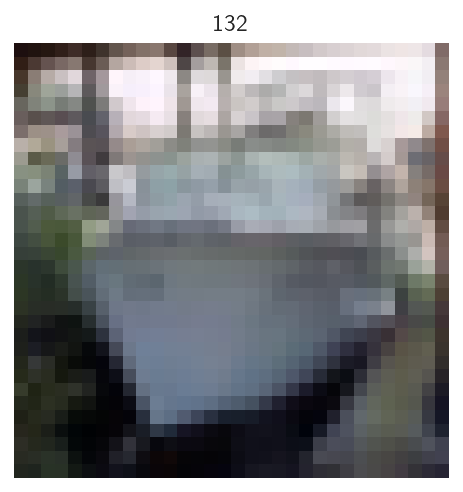

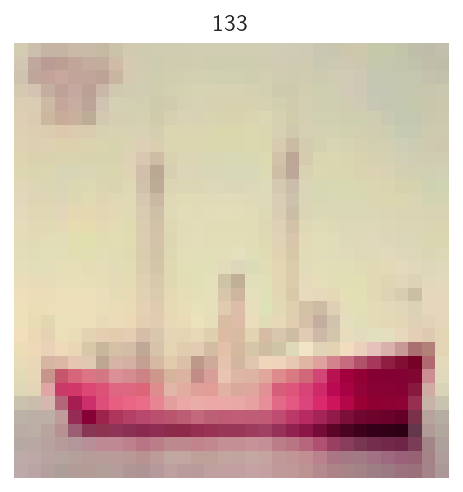

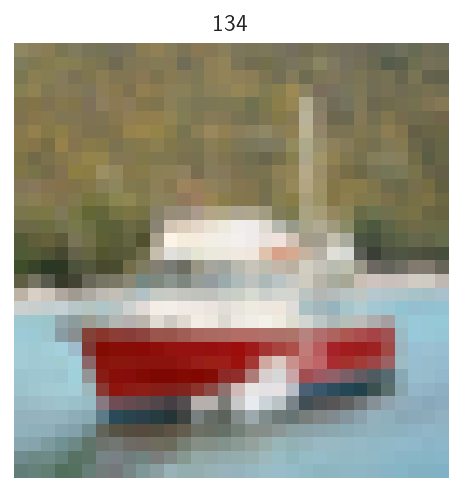

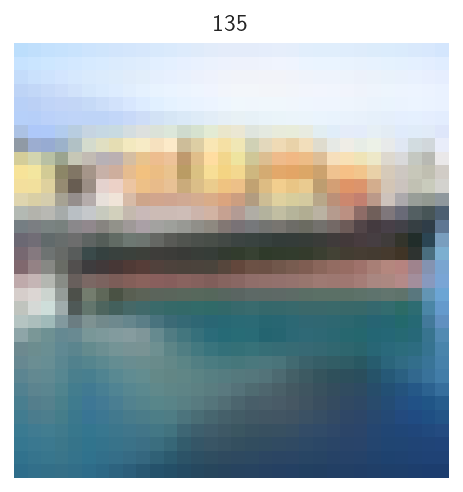

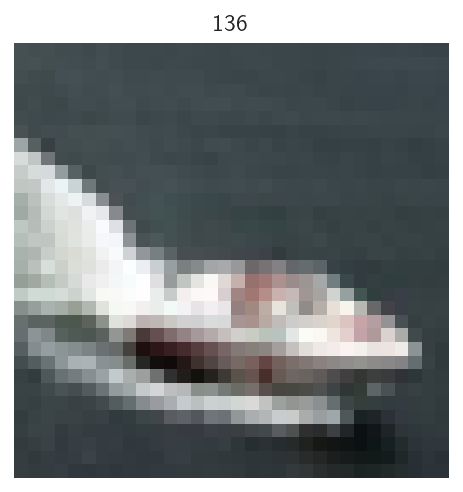

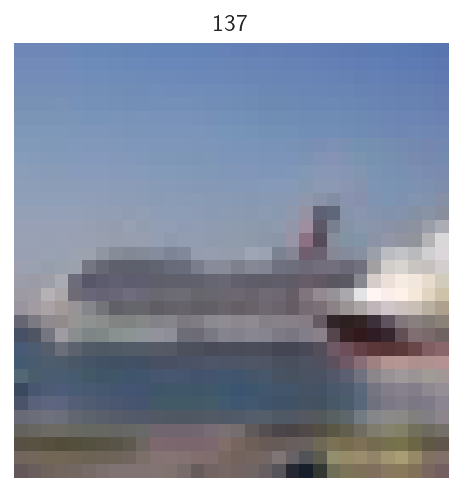

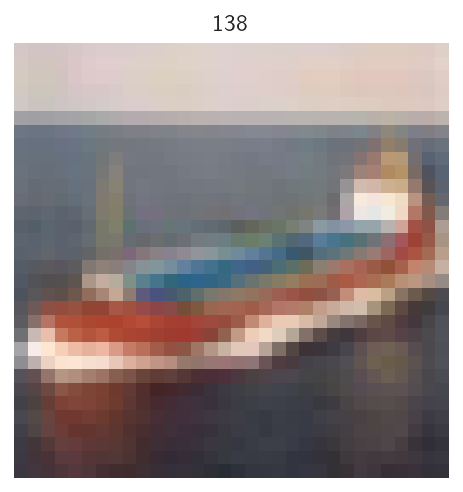

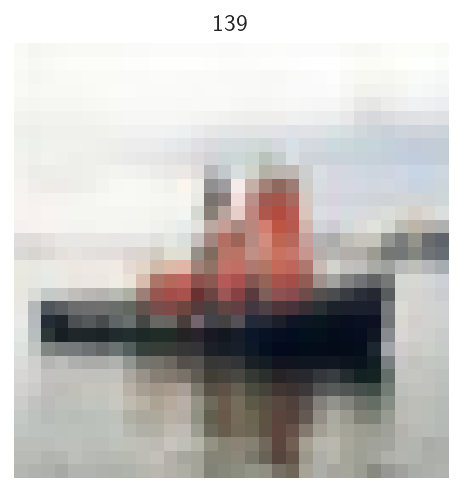

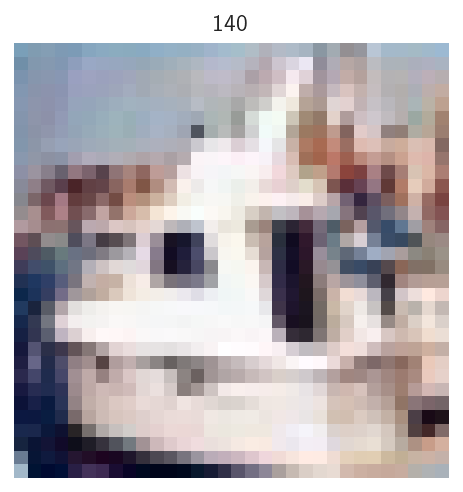

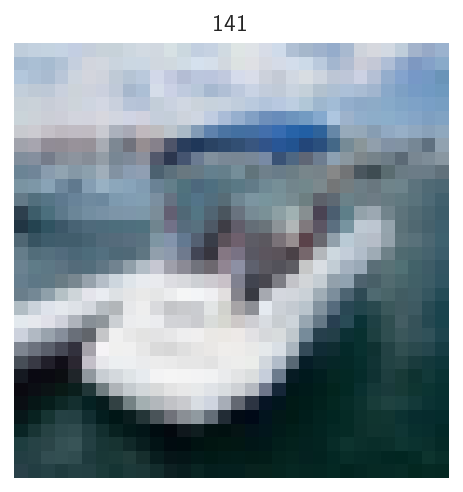

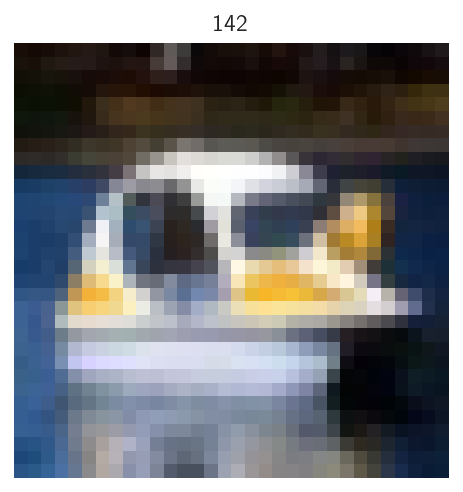

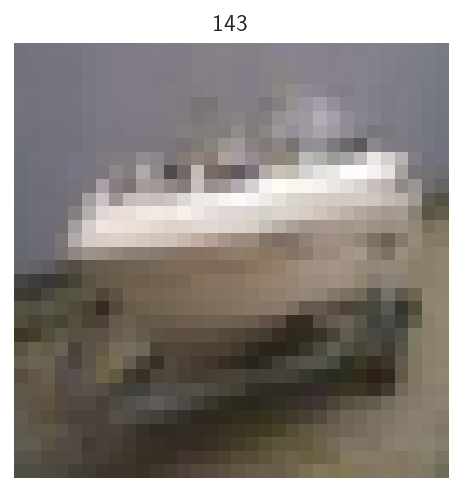

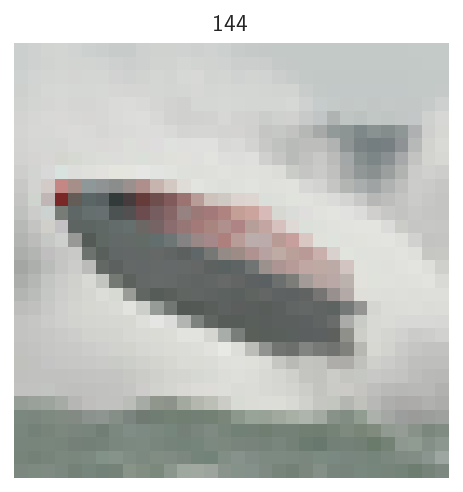

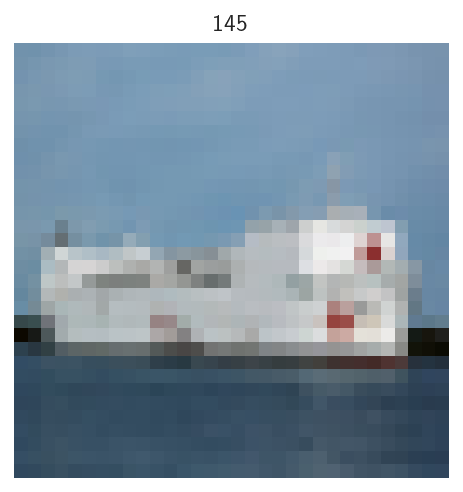

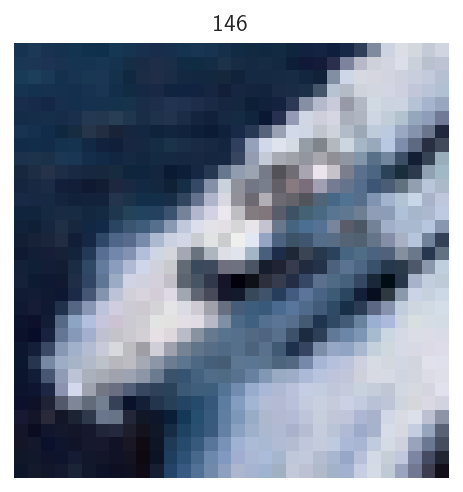

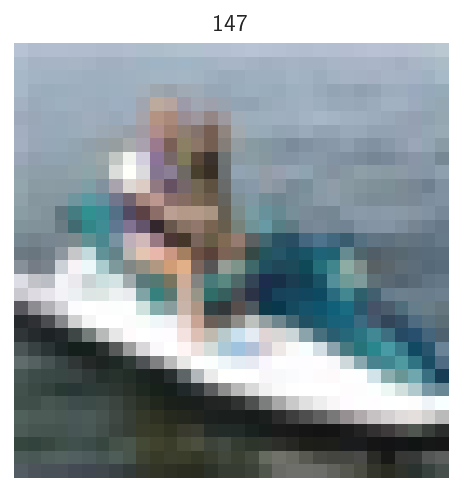

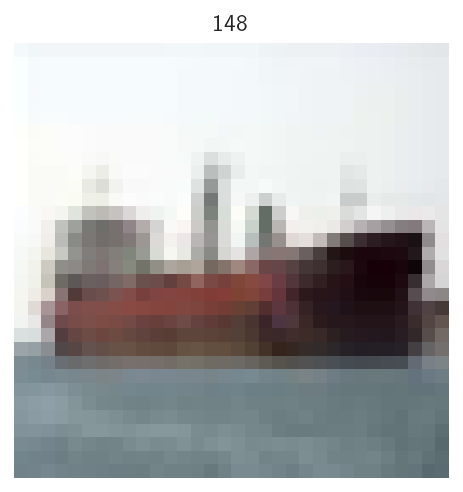

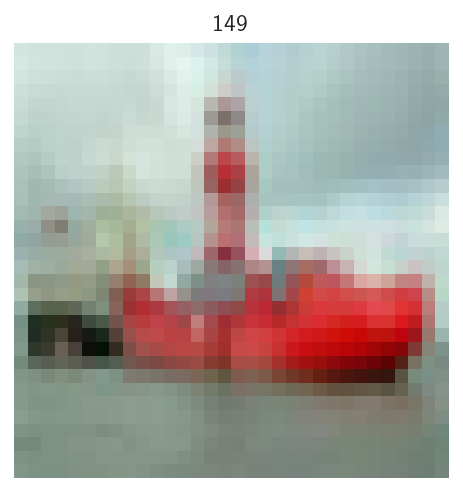

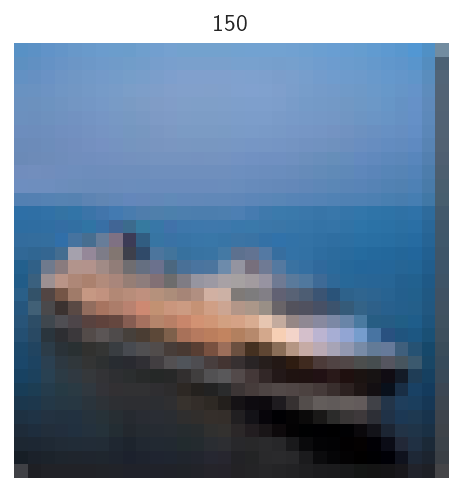

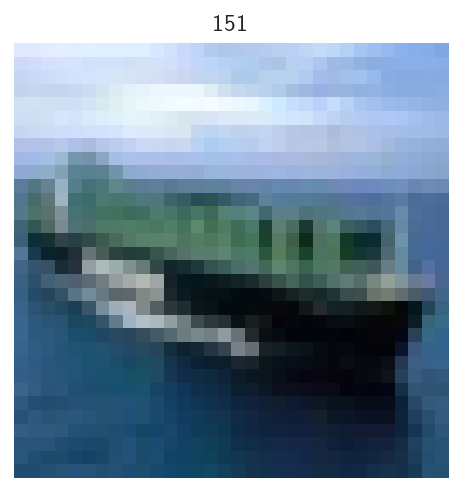

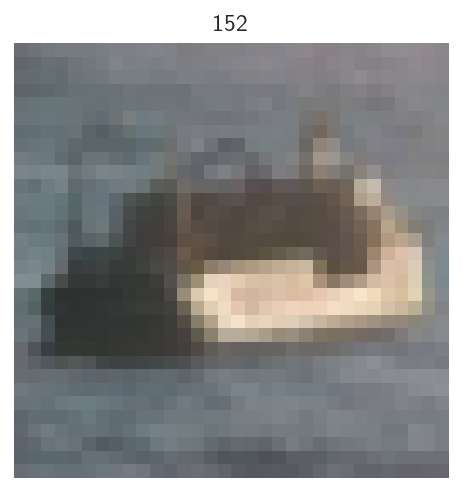

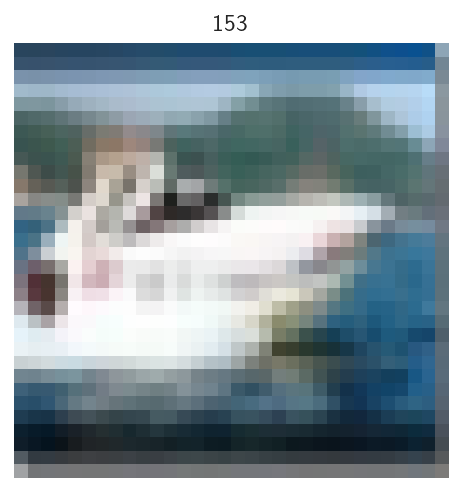

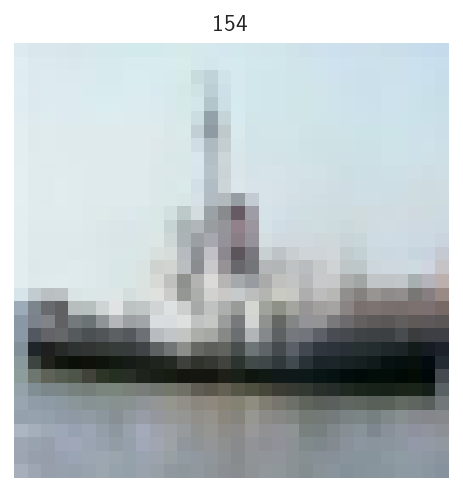

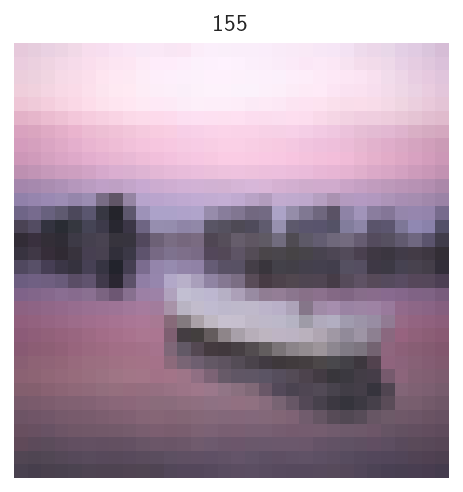

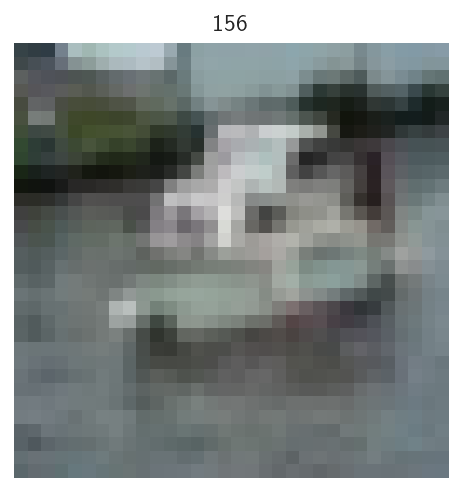

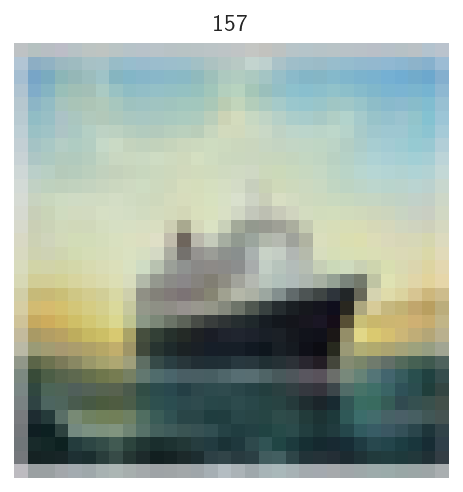

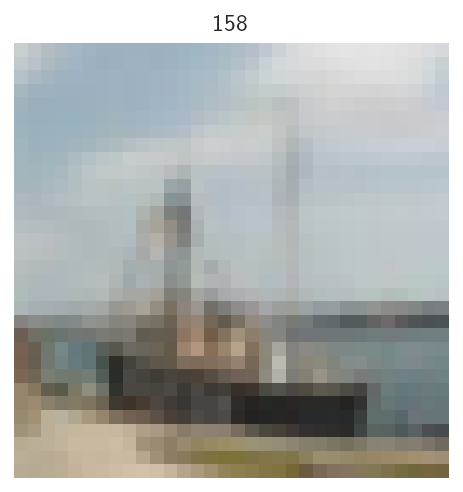

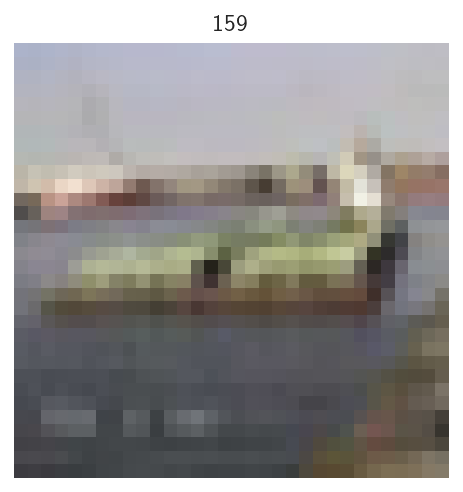

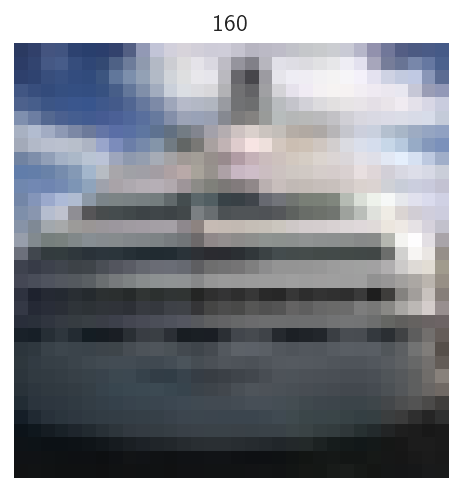

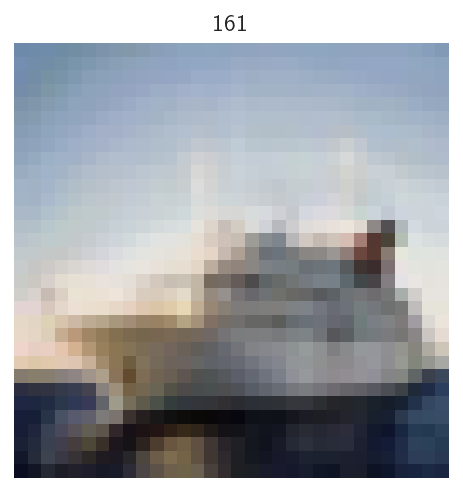

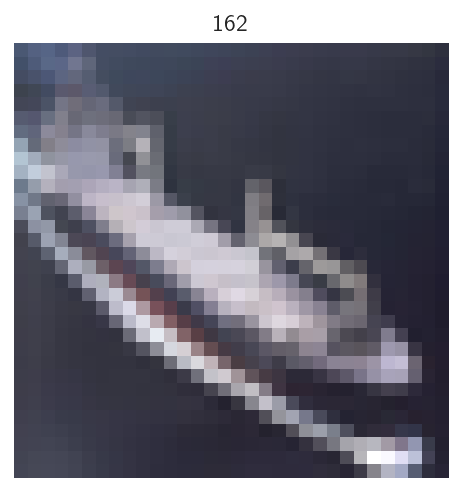

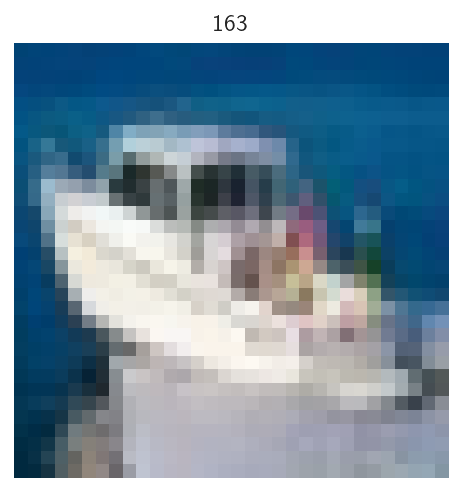

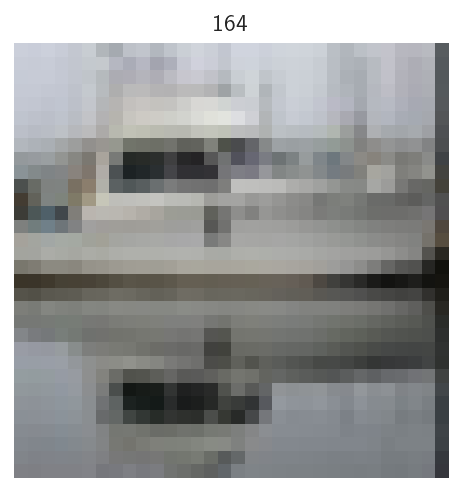

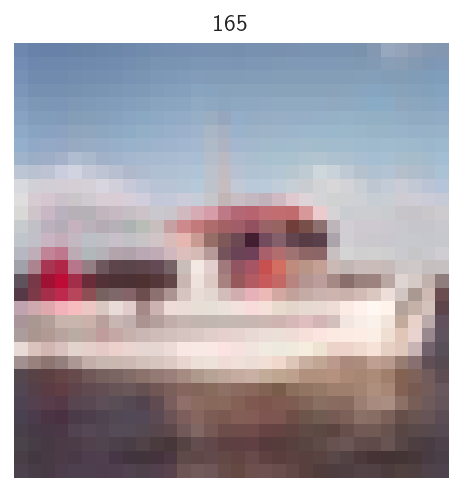

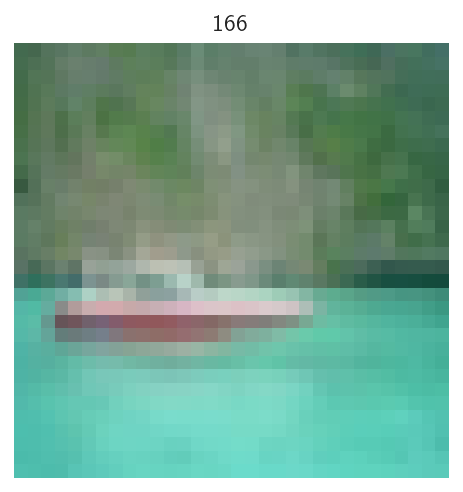

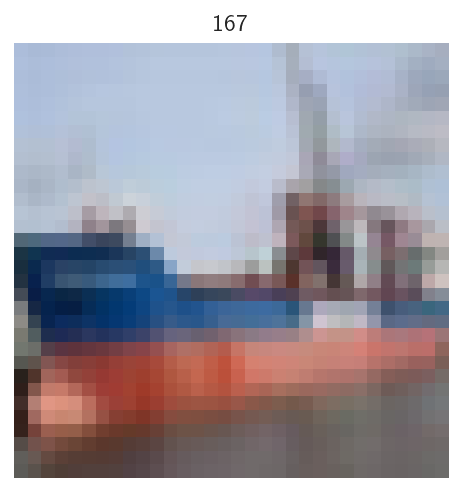

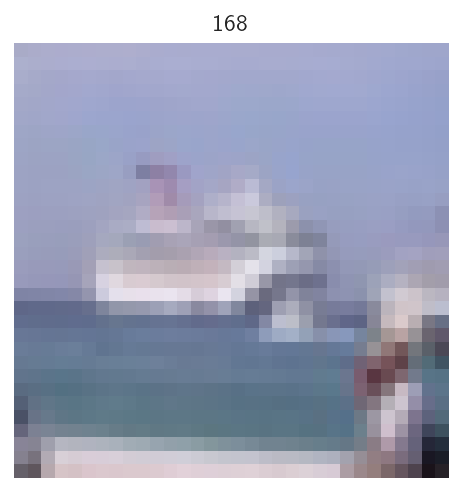

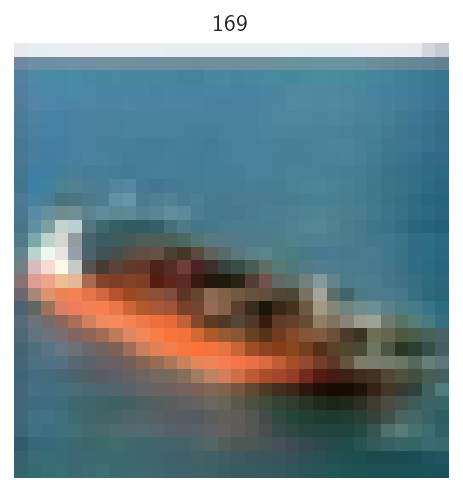

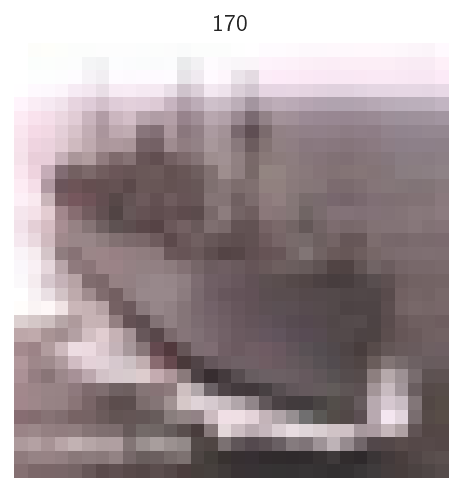

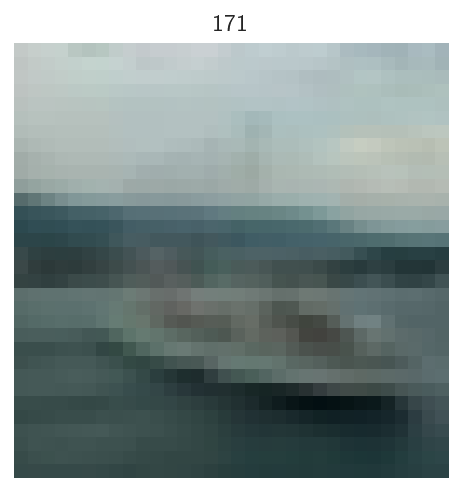

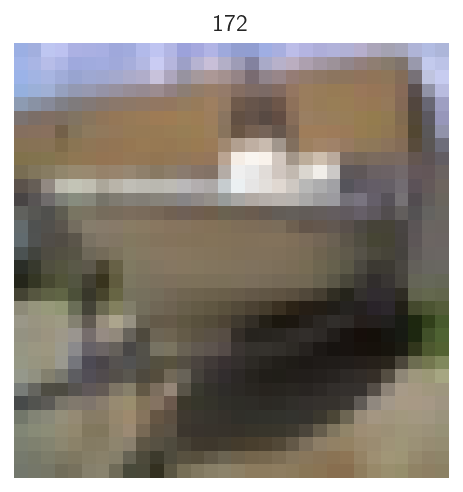

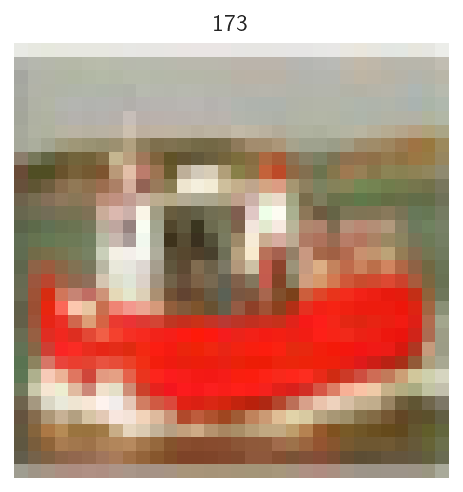

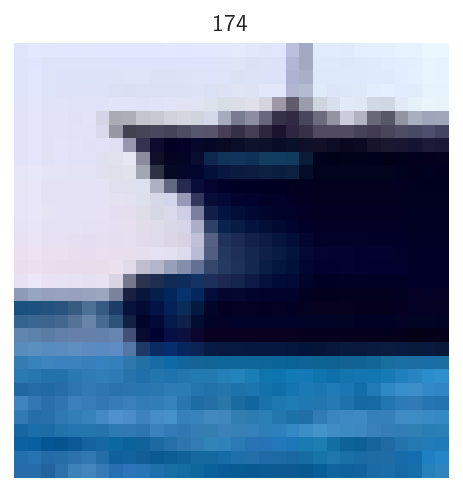

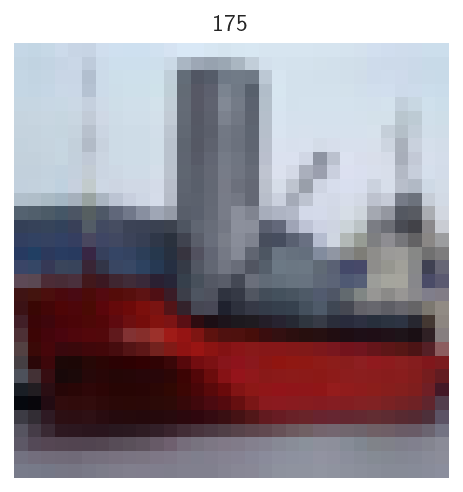

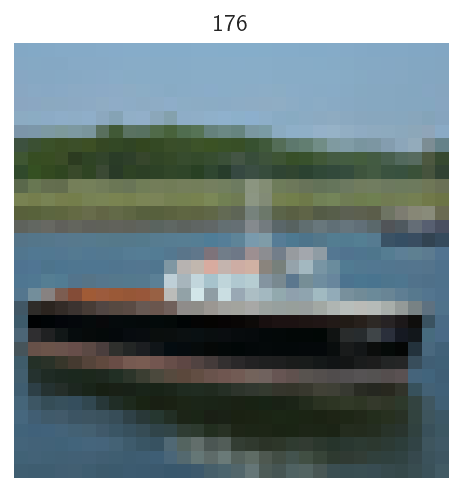

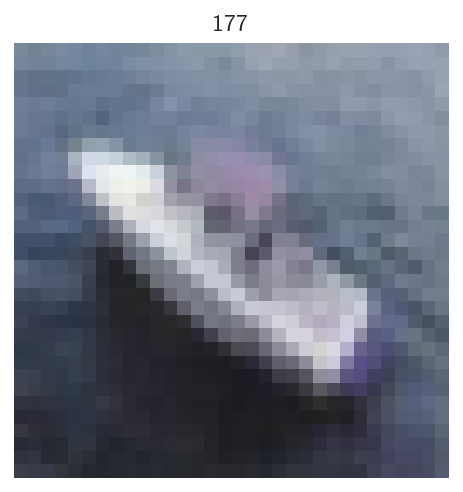

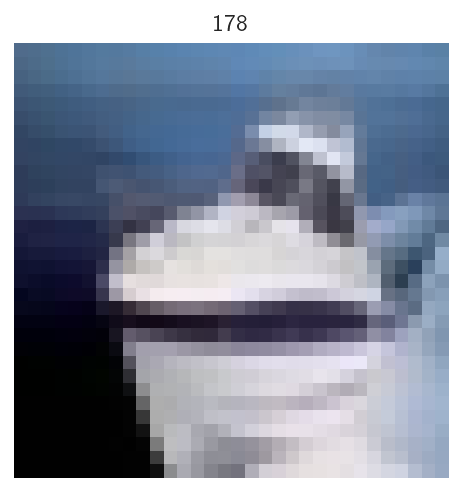

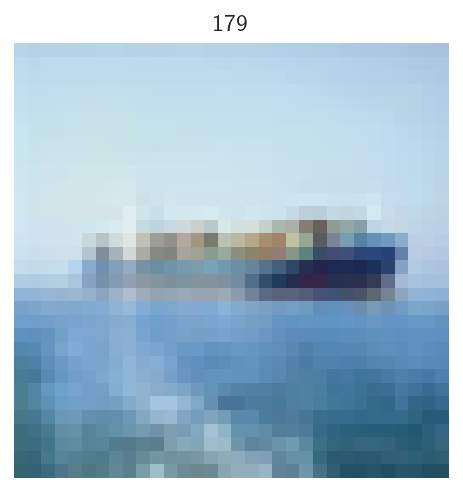

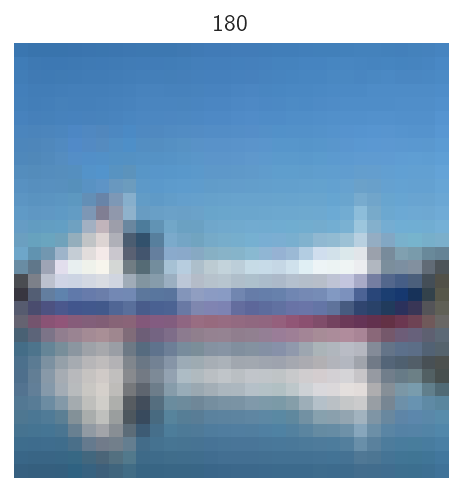

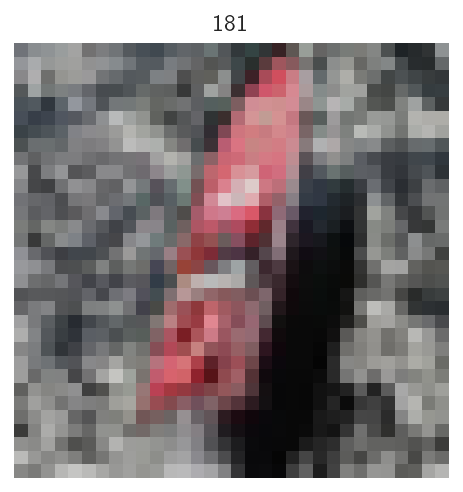

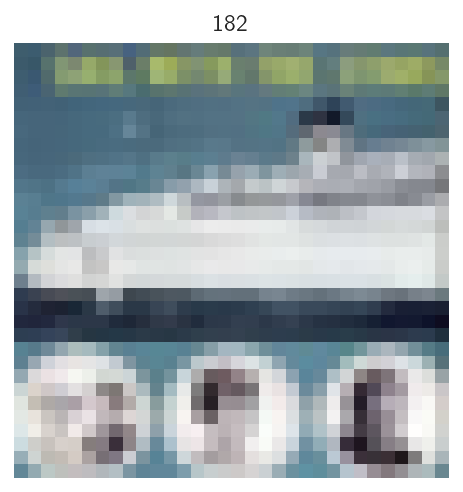

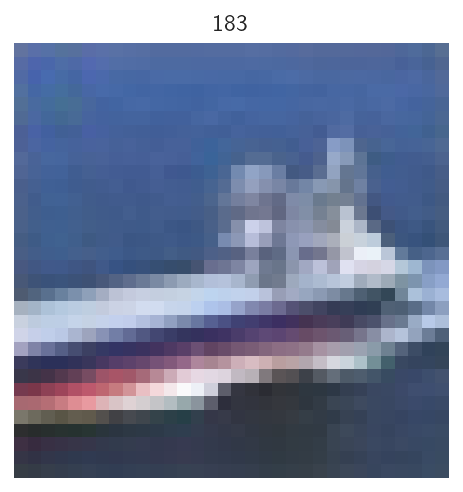

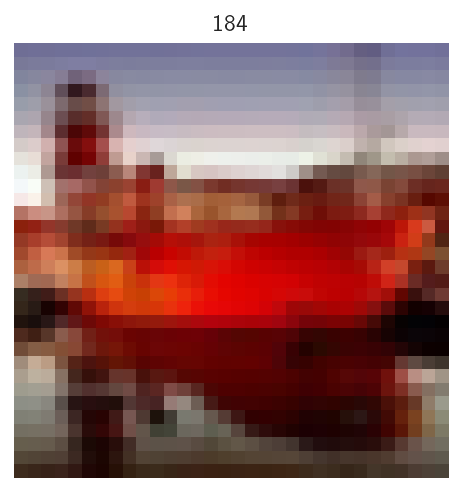

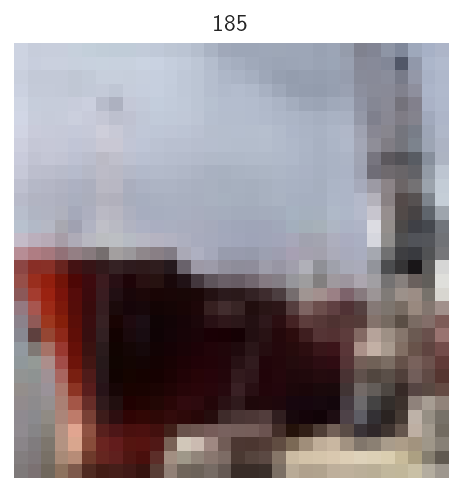

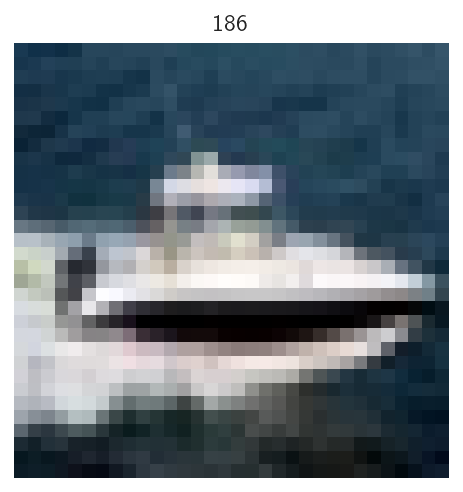

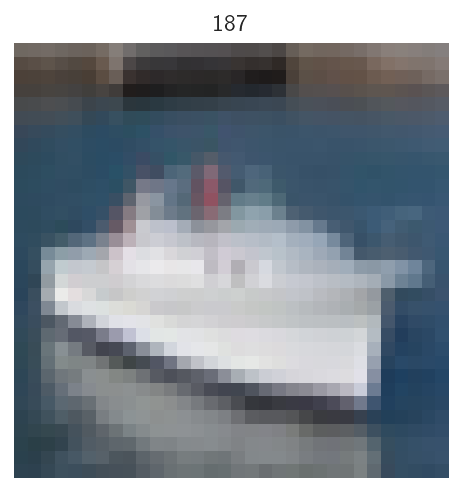

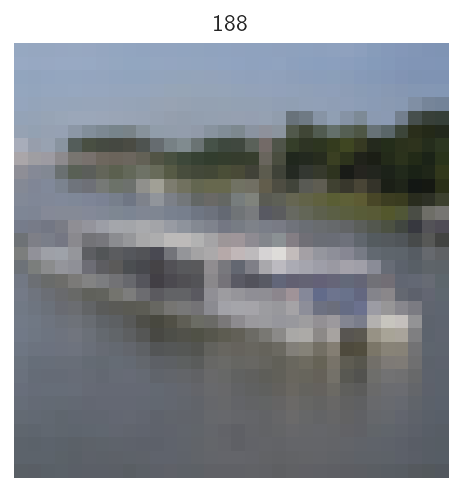

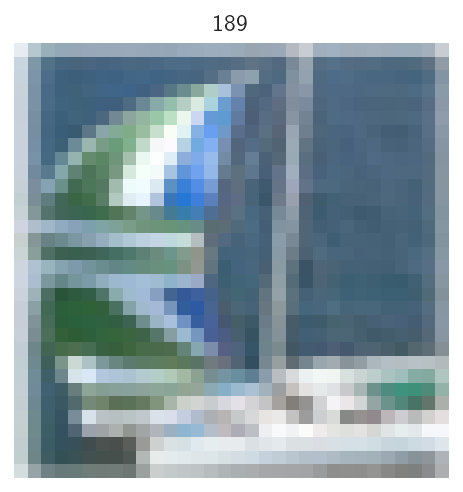

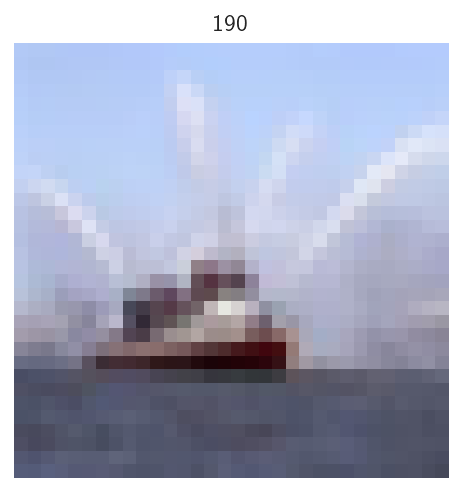

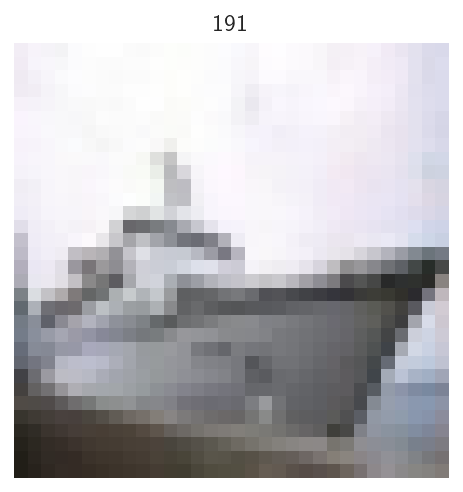

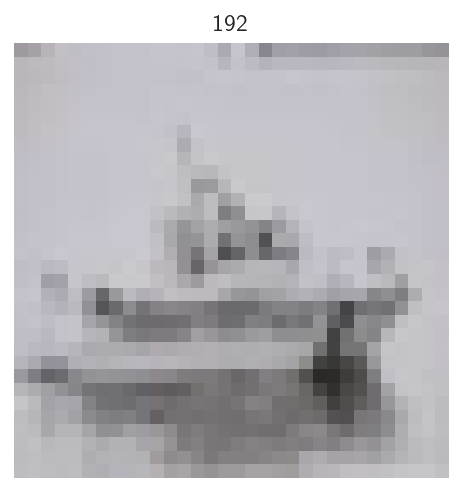

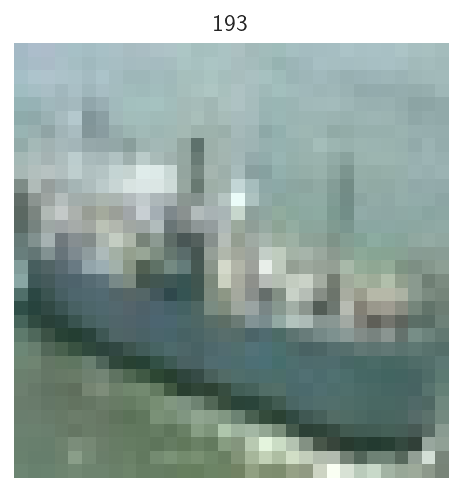

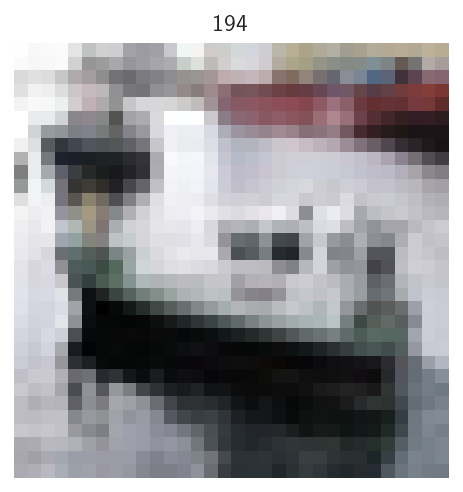

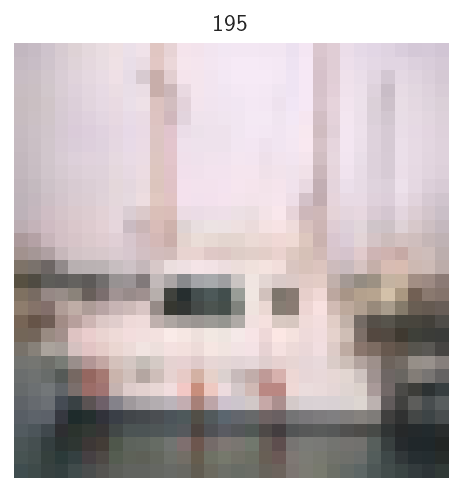

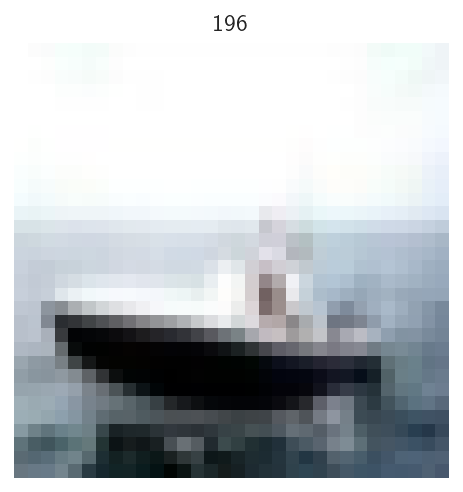

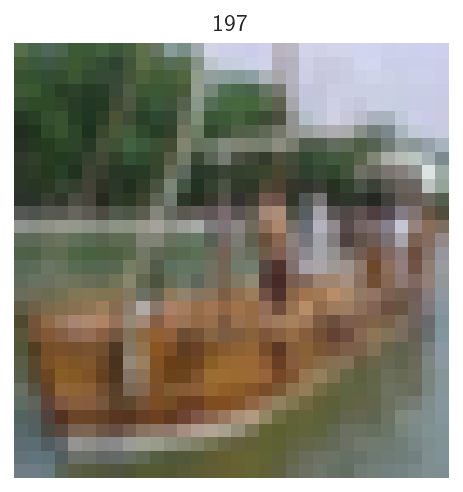

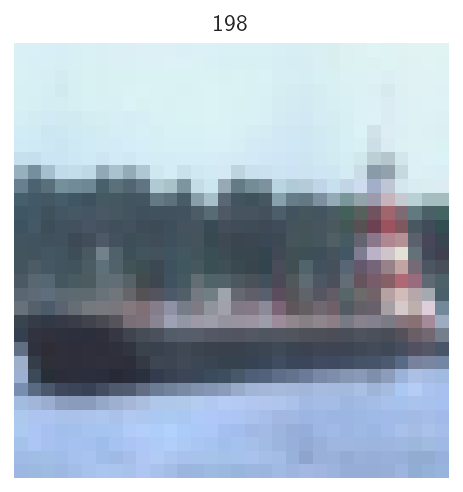

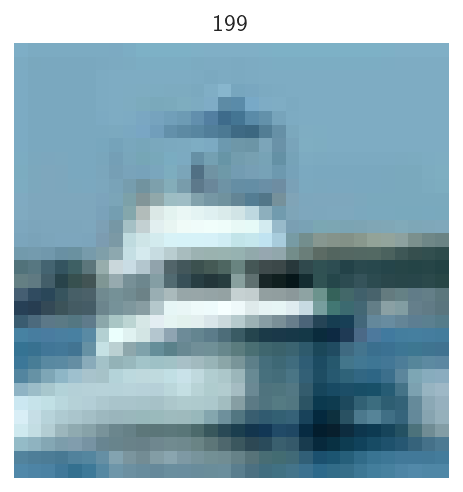

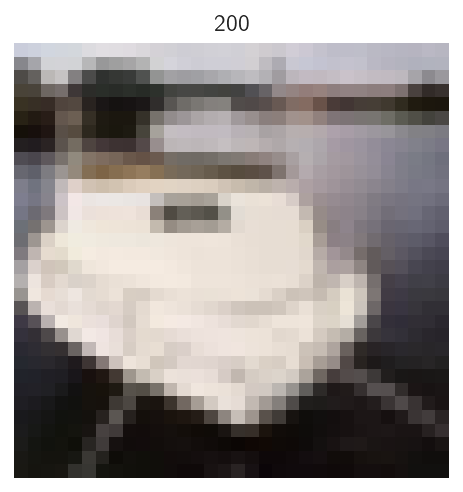

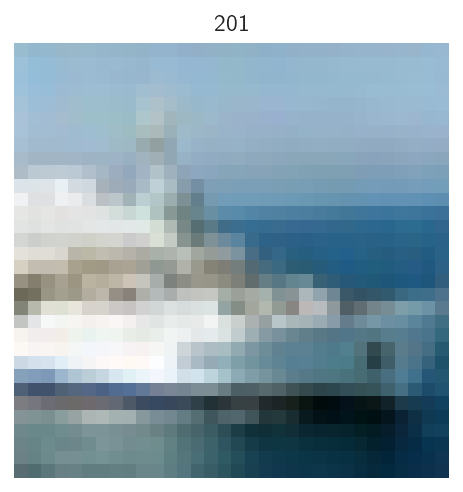

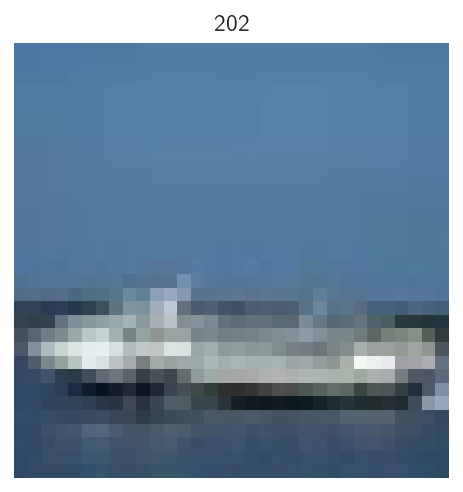

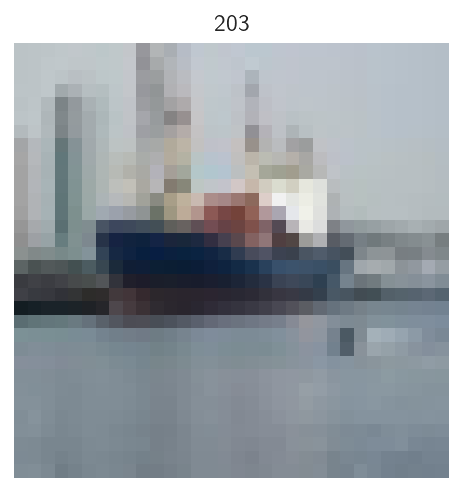

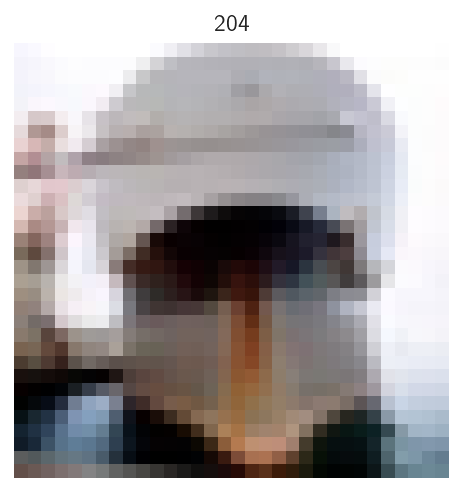

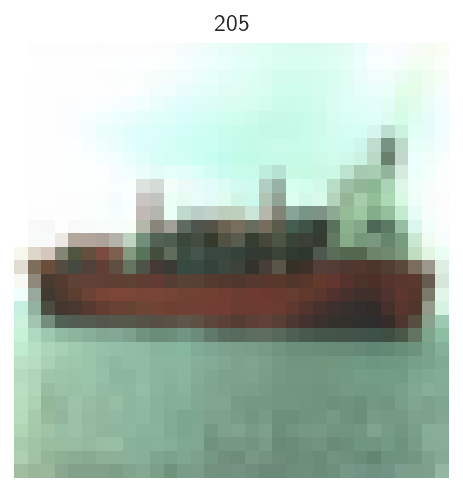

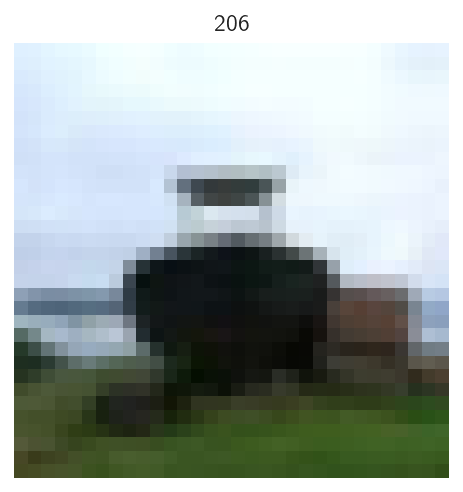

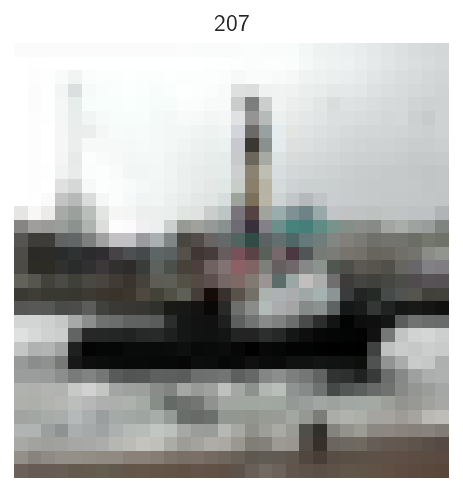

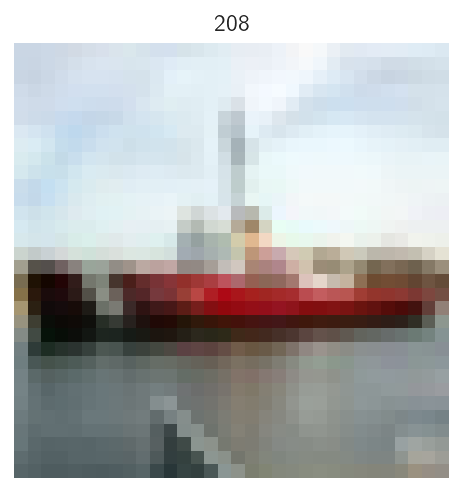

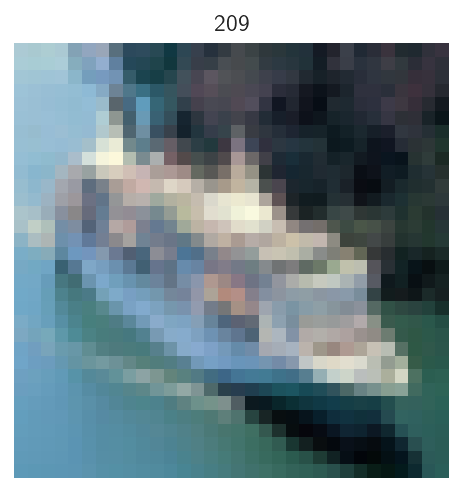

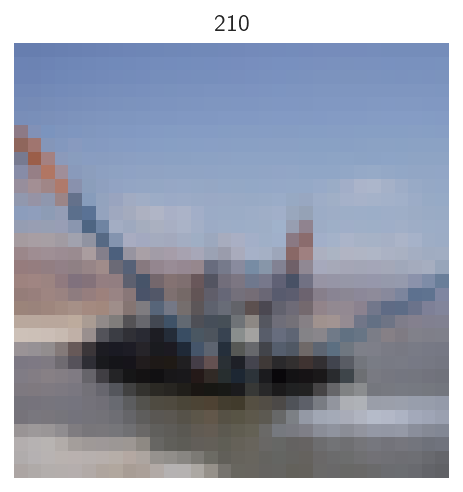

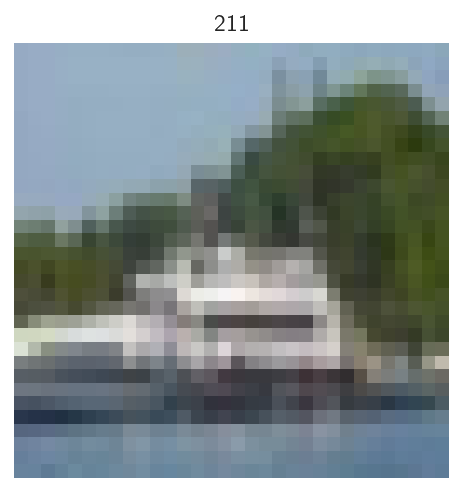

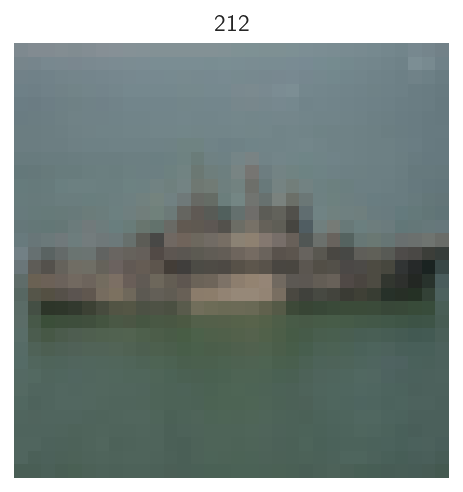

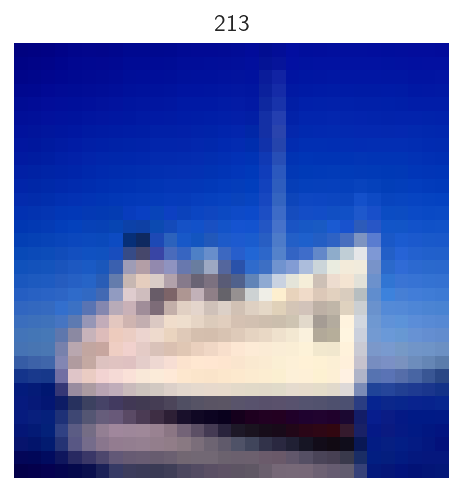

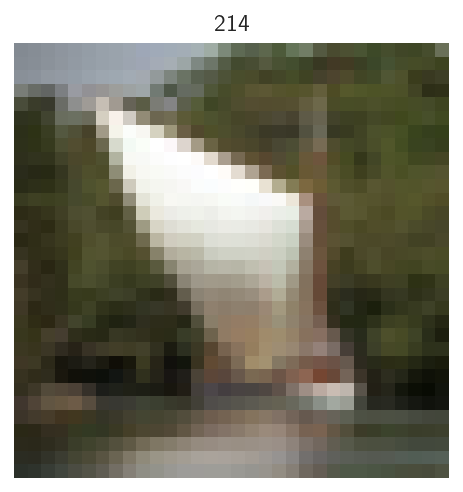

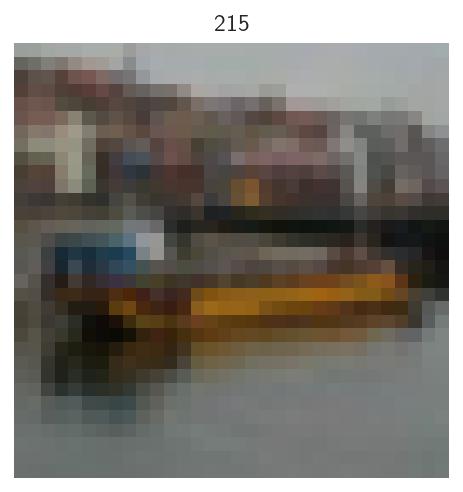

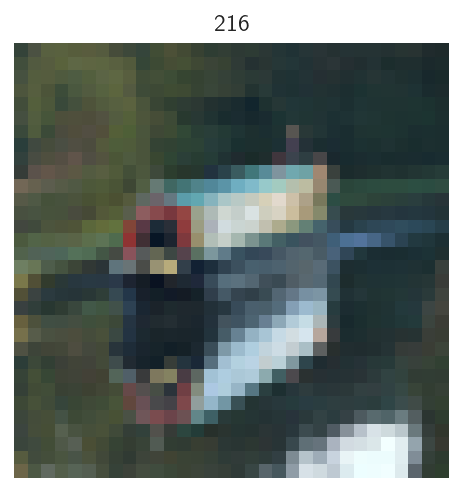

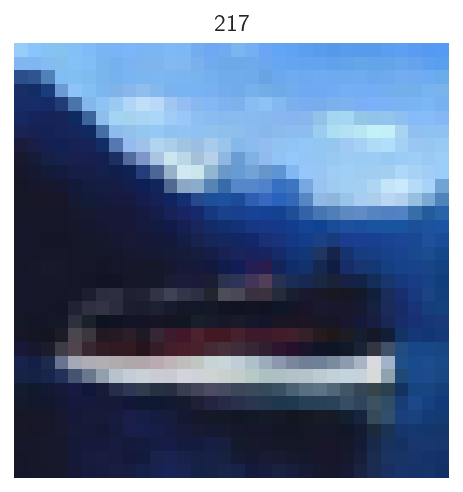

In [ ]:
f = FloatProgress(min=0, max=1000)
display(f)
    
for i, val in enumerate(np.where(Ttest == 8)[0]):
    plt.imshow(np.moveaxis(Xtest[val,...], 0, 2), interpolation='nearest')
    plt.title(i)
    plt.axis('off')
    plt.show()
    f.value += 1

In [8]:
def run_parameters(Xtrain, Ttrain, Xtest, Ttest, n_epochs, rhos, conv_layers, kernels,
                   conn_layers, use_gpu=False):
    results = pd.DataFrame(columns=['algo', 'epochs', 'rho', 'conv_layers', 'kernels', 
                                    'conn_layers', 'train_accuracy', 'test_accuracy'])
    algo = 'Adam'
    top = 0
    f = FloatProgress(min=0, max=(len(n_epochs) * len(rhos) * len(conv_layers) * len(conn_layers)))
    display(f)
    for epochs, rho, conv, conn in itertools.product(n_epochs, rhos, conv_layers, conn_layers):
        
        kern = [] if len(conv) == 0 else kernels[len(conv) - 1]
        
        nnet = nnc.NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                               image_size=Xtrain.shape[2],
                                               n_units_in_conv_layers=conv, 
                                               kernels_size_and_stride=kern,
                                               n_units_in_fc_hidden_layers=conn,
                                               classes=np.unique(Ttrain), use_gpu=use_gpu)

        nnet.train(Xtrain, Ttrain, epochs, algo, learning_rate=rho, verbose=False)

        classes, Y = nnet.use(Xtrain)
        train_percent = ml.percent_correct(Ttrain, classes)

        classes, Y = nnet.use(Xtest)
        test_percent = ml.percent_correct(Ttest, classes)
        
        results.loc[len(results)] = [algo, epochs, rho, conv, kern,
                                     conn, train_percent, test_percent]
        
        if test_percent > top:
            best_nnet = nnet
            top = test_percent
        
        f.value += 1
    
    return results, best_nnet

In [ ]:
# n_epochs = [ 2000 ]

# rhos = [ 0.001 ]

# conn_layers = [[]]

# conv_layers = [[],
#                [],
#                [35,35,35,35]]

# kernels = [ [],
#             [(6,1), (6,1), (8,1), (5,2)]]
#             #[(4, 2), (5, 2), (2, 1)]]

# results, best_nnet = run_parameters(Xtrain, Ttrain, Xtest, Ttest, n_epochs,
#                                     rhos, conv_layers, kernels, conn_layers, use_gpu=True)

In [ ]:
n_epochs = [ 3000 ]

rhos = [ 0.01, 0.001 ]

conn_layers = [[]]

conv_layers = [[]] + [[nu] * nl for nu in [15, 25] for nl in range(3, 4)]

kernels = [ [],
            [],
            [(4, 2), (5, 2), (2, 1)]]

results, best_nnet = run_parameters(Xtrain, Ttrain, Xtest, Ttest, n_epochs,
                                    rhos, conv_layers, kernels, conn_layers, use_gpu=True)

In [ ]:
df = results.sort_values(by=['test_accuracy'], ascending=False)
print('Total of {} trials'.format(results.shape[0]))
df.head(10)

Original input image: 
- $d\times d$ of $c$ channels

First convolutional layer with $u_1$ units having kernels sized $k_1\times k_1$ and strides of $s_1$
- input is $d\times d$ of $c$ channels
- output is $z_1\times z_1$ of $u_1$ channels, where $z_1 = \frac{d - k_1}{s_1} + 1$

In [ ]:
nnet = nnc.NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[25],
                                   kernels_size_and_stride=[[4, 3]],
                                   n_units_in_fc_hidden_layers=[40,40], 
                                   classes=classes,
                                   use_gpu=True)

nnet.train(Xtrain.astype(np.float32), Ttrain.astype(np.float32), 2000, learning_rate=0.0001, verbose=True)

In [ ]:
plt.plot(nnet.get_error_trace())
plt.xlabel('Epochs')
plt.ylabel('MSE');

In [ ]:
classes, Y    = nnet.use(Xtrain)
train_percent = ml.percent_correct(Ttrain, classes)

classes, Y    = nnet.use(Xtest)
test_percent  = ml.percent_correct(Ttest, classes)

print(f'Train Percentage: {train_percent}, Test Percentage: {test_percent}')

In [ ]:
_ = ml.confusion_matrix(Ttest, classes, np.unique(Ttest))

In [ ]:
def change_pixel(Xset, pixels_to_change=1, pertrub='stuck'):
    Xcopy    = copy.copy(Xset)
    bounds   = Xcopy.shape[-1]
    
    for i in range(len(Xcopy)):
        for rounds in range(pixels_to_change):
            X = np.random.randint(bounds)
            Y = np.random.randint(bounds)
            
            for C in range(Xcopy.shape[1]):
                
                if pertrub == 'stuck':
                    r = np.random.random(1)
                elif pertrub == 'dead':
                    r = 0
                elif pertrub == 'hot':
                    r = 1
                    
                Xcopy[i:i+1, C:C+1, Y:Y+1, X:X+1] = r
            
    return Xcopy

def imshow(Xset, Xcopy, Tset, same_index, model, name='grid.pdf'):
    plt.figure(figsize=(9, 4))
    
    n_display = same_index[:14] if len(same_index) > 14 else same_index

    Xcopy_classes, _ = nnet.use(Xcopy[n_display])
    Xset_classes, _  = nnet.use(Xset[n_display])
    
    print(Xcopy.shape, Xset.shape)
    
    for i, val in enumerate(n_display):
        plt.subplot(2, 7, i + 1)
        
        if model == 'MNIST':
            plt.imshow(Xcopy[val, :].reshape(Xset.shape[-1], Xset.shape[-1]),
                       interpolation='nearest', cmap='binary')
        if model == 'CIFAR':
            plt.imshow(np.moveaxis(Xcopy[val,...], 0, 2), interpolation='nearest')
        
        plt.title('$X_i$: {0}, $M_i$: {1},\n$T_i$: {2}'.format(Xset_classes[i][0], 
                                                              Xcopy_classes[i][0], 
                                                              Tset[val][0]))
        plt.axis('off');
        
    plt.tight_layout();
    plt.savefig(name, bbox_inches='tight')
    plt.show();

def classified_diff(Xset, Xcopy, Tset):
    Xset_classes, _  = nnet.use(Xset)
    Xcopy_classes, _ = nnet.use(Xcopy)
    
    diff_index = [ i for i in range(len(Xset_classes)) 
                  if Xset_classes[i] == Tset[i] 
                  and Xset_classes[i] != Xcopy_classes[i] ]
    
    return diff_index, 100 - ml.percent_correct(Xset_classes, Xcopy_classes)

def change_in_pixels_plot(Xset, Tset, end_pixel_val=10, trials_per_pixel=5, 
                          errorbar=True, pertrub='stuck', name='img.pdf'):
    plt.figure(figsize=(6, 4))
    change = []
    
    f = FloatProgress(min=0, max=(end_pixel_val * trials_per_pixel))
    display(f)

    for pixels in range(end_pixel_val):
        percent_diff_arr = []
        for trial in range(trials_per_pixel):
            Xcopy = change_pixel(Xtest, pixels_to_change=pixels+1, pertrub='stuck')
            percent_diff_arr.append(classified_diff(Xtest, Xcopy, Ttest)[1])
            
            f.value += 1
        
        change.append(percent_diff_arr)
    
    change = np.array(change)
    
    x = np.arange(1, change.shape[0] + 1)
    y = np.mean(change, axis=1)
    yerr = np.std(change, axis=1)
    
    if errorbar:
        plt.errorbar(x, y, yerr=yerr, marker='.', 
                     lw=1, capsize=5, capthick=1.5, markeredgecolor='k')
    else:
        plt.plot(x, y, marker='.', lw=1, markeredgecolor='k')
        
    plt.xlabel('Number of Pixels Changed')
    plt.ylabel('Mean \% Misclassified')
    plt.grid(True); plt.tight_layout(); 
    plt.savefig(name, bbox_inches='tight')
    plt.show();

In [ ]:
pixels_to_change = 1
Xcopy = change_pixel(Xtest, pixels_to_change=pixels_to_change)

diff_index, percent_diff = classified_diff(Xtest, Xcopy, Ttest)

print(f'''Total of {len(diff_index)} misclassified samples,
      with a {percent_diff:.3f}% difference from test by changing {pixels_to_change} pixel(s)''')

imshow(Xtest, Xcopy, Ttest, diff_index, model='CIFAR', name='media/cifar_example_1px_stuck.pdf')
print(class_names)

change_in_pixels_plot(Xtest, Ttest, end_pixel_val=5, trials_per_pixel=25, name='media/cifar_change_5px_stuck.pdf')

In [ ]:
pixels_to_change = 1
Xcopy = change_pixel(Xtest, pixels_to_change=pixels_to_change, pertrub='dead')

diff_index, percent_diff = classified_diff(Xtest, Xcopy, Ttest)

print(f'''Total of {len(diff_index)} misclassified samples,
      with a {percent_diff:.3f}% difference from test by changing {pixels_to_change} pixel(s)''')

imshow(Xtest, Xcopy, Ttest, diff_index, model='CIFAR', name='media/cifar_example_1px_dead.pdf')
print(class_names)

change_in_pixels_plot(Xtest, Ttest, end_pixel_val=5, trials_per_pixel=25, name='media/cifar_change_5px_dead.pdf')

In [ ]:
pixels_to_change = 1
Xcopy = change_pixel(Xtest, pixels_to_change=pixels_to_change, pertrub='hot')

diff_index, percent_diff = classified_diff(Xtest, Xcopy, Ttest)

print(f'''Total of {len(diff_index)} misclassified samples,
      with a {percent_diff:.3f}% difference from test by changing {pixels_to_change} pixel(s)''')

imshow(Xtest, Xcopy, Ttest, diff_index, model='CIFAR', name='media/cifar_example_1px_hot.pdf')
print(class_names)

change_in_pixels_plot(Xtest, Ttest, end_pixel_val=5, trials_per_pixel=25, name='media/cifar_change_5px_hot.pdf')

In [ ]:
_ = ml.confusion_matrix(Ttest, nnet.use(Xcopy)[0], np.unique(Ttest))

In [ ]:
_ = ml.confusion_matrix(Ttest, nnet.use(Xtest)[0], np.unique(Ttest))